# IClassification    des    chiffres    manuscrits avec le deep learning





Ce TP a pour objectif de vous faire découvrir les fondamentaux du Deep Learning à travers la classification de chiffres manuscrits. Vous réussirez à développer des modèles ayant jusqu'à 99% de bonne classification. Dans un premier temps, vous développerez un simple Fully Connected Neural Networks suivi d'un Convolutional Neural Networks. Vous découvrirez ensuite la technique du Transfer Learning, utilisé lorsque la quantité de données est limité. Vous finirez par développer un Autoencodeur, modèle qui permet d'apprendre une représentation comprésée des données.


# Jeu de données MNIST

La base MNIST est un jeu de données regroupant des images de chiffres manuscrits. Elle est composé de 60,000 images pour l'entraînement de modèles prédictifs et de 10,000 images pour le test de ces modèles. Les images sont au format 28 x 28 pixels en couleur noir et blanc.

<img src='https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png'>

## Importation des modules Python

In [1]:
import numpy as np                     # Bibliothèque Python pour le calcul scientifique
import matplotlib.pyplot as plt        # Bibliothèque Python capable de produire des graphs
import seaborn as sns                  # Bibliothèque de visualisation de données basée sur matplotlib
import random                          # Pour la génération de nombres aléatoire
from keras.datasets import mnist       # Importation du jeu de données MNIST via le framework keras
from keras.utils import np_utils       # Permet d'importer des fonctions lié a numpy 
                                       # Keras est une bibliothèque de Deep Learning (développé par François Chollet, ingénieur français)

# Nécessaire pour afficher des graphiques au sein du jupyter notebook
%matplotlib inline                     

In [2]:
# La base MNIST est séparé en 60000 images de dimension 28 x 28 pixels pour l'apprentissage et de 10000 images de dimension 28 x 28 pixels pour le test.
(X_train, y_train), (X_test, y_test) = mnist.load_data()

print("Dimension X_train : ", X_train.shape)
print("Dimension y_train : ", y_train.shape)
print("Dimension X_test : ", X_test.shape)
print("Dimension y_test : ", y_test.shape)

Dimension X_train :  (60000, 28, 28)
Dimension y_train :  (60000,)
Dimension X_test :  (10000, 28, 28)
Dimension y_test :  (10000,)


## Distribution des différentes classes dans les données d'apprentissage

C:\Users\karim\anaconda3\envs\tensorflow\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

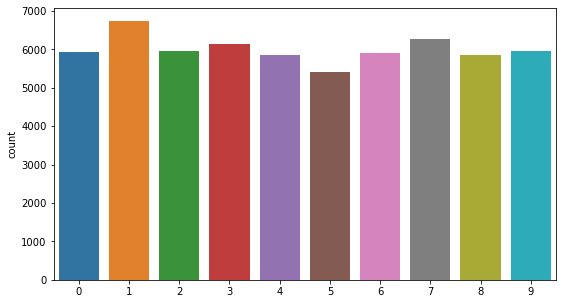

In [3]:
plt.rcParams['figure.figsize'] = (9, 5)
sns.countplot(y_train)

## Distribution des différentes classes dans les données test

C:\Users\karim\anaconda3\envs\tensorflow\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

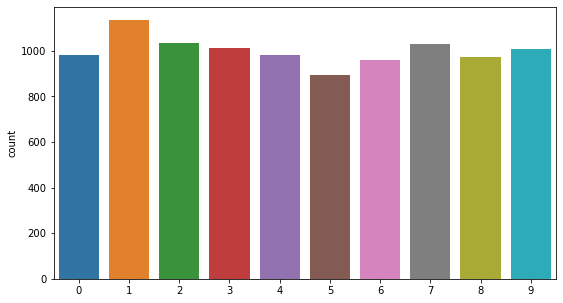

In [4]:
plt.rcParams['figure.figsize'] = (9, 5)
sns.countplot(y_test)

Affichage de 16 images aléatoires de la base d'apprentisage

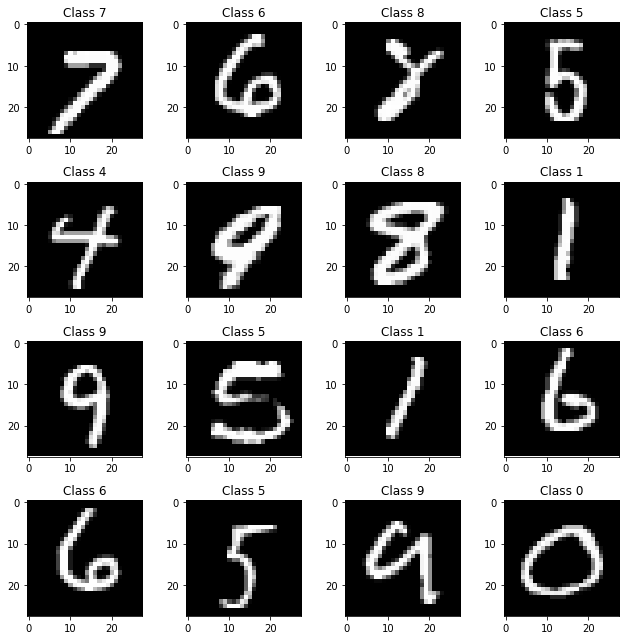

In [5]:
plt.rcParams['figure.figsize'] = (9, 9)

for i in range(16):
    plt.subplot(4,4,i+1)
    idx = random.randint(0, len(X_train))
    plt.imshow(X_train[idx], cmap='gray', interpolation='none')
    plt.title("Class {}".format(y_train[idx]))
    
plt.tight_layout()

0  0  0  0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0  0  0  0  0  
0  0  0  0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0  0  0  0  0  
0  0  0  0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0  0  0  0  0  
0  0  0  0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0  0  0  0  0  
0  0  0  0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0  0  0  0  0  
0  0  0  0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0  0  0  0  0  
0  0  0  0    0    0    0    0    0    0    0   13   57  135  198  150   13    0    0    0    0    0    0    0  0  0  0  0  
0  0  0  0    0    0    0    0    0    0   10  156  252  252  253  252   77   26    0    0    0    0    0    0  0  0  0  0  


Text(0.5, 1.0, 'Class 0')

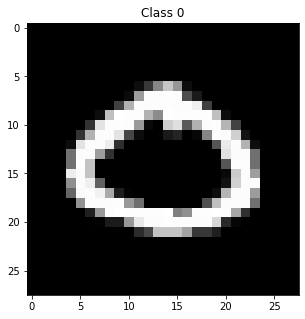

In [6]:
# Fonction qui permet d'afficher de façon propre la matrice associé à une image
def matprint(mat, fmt="g"):
    col_maxes = [max([len(("{:"+fmt+"}").format(x)) for x in col]) for col in mat.T]
    for x in mat:
        for i, y in enumerate(x):
            print(("{:"+str(col_maxes[i])+fmt+"}").format(y), end="  ")
        print("")
 
idx = random.randint(0, len(X_train)) # Permet de générer un indice aléatoire   
matprint(X_train[idx])
plt.rcParams['figure.figsize'] = (5, 5)
plt.imshow(X_train[idx], cmap='gray', interpolation='none')
plt.title("Class {}".format(y_train[idx]))

Chaque image est composé de pixel avec des valeurs allant de 0 (tout noir) à 255 (tout blanc). Un pixel est donc codé sur 8 bits (2**8=256)

## Redimensionnement des images

Un réseau de neurones Fully Connected ne peut pas accepter d'images de dimension 28 x 28 pixels en entrée. Il pourra en revanche accepter un vecteur,  ici de dimension 784 (28 * 28) correspondant à l'aplatissement des images de la base MNIST.

Nous normaliserons également les données pour qu'elles soient dans la plage [0-1] plutôt que [0-255]. Cela  falicitera le processus d'optimisation des paramètres du modèle.

<img src='https://achintavarna.files.wordpress.com/2017/11/mnist_2layers.png?w=634' >

<img src='https://miro.medium.com/max/818/1*3iZTK8i072gCxdISo5qEdQ.png' width="700">

In [7]:
X_train = X_train.reshape(60000, 784)   # redimensionnement des 60,000 28 x 28 matrices en 60,000 vecteurs de dimension 784        
X_test = X_test.reshape(10000, 784)     # redimensionnement des 10,000 28 x 28 matrices en 10,000 vecteurs de dimension 784        

X_train = X_train.astype('float32')     # changement du type de données 
X_test = X_test.astype('float32')

X_train /= 255                          # normalisation des 784 pixels de chacune des images pour le training et le test
X_test /= 255

print("Dimension du jeu de données d'entraînement", X_train.shape)
print("Dimension du jeu de données de test", X_test.shape)

Dimension du jeu de données d'entraînement (60000, 784)
Dimension du jeu de données de test (10000, 784)


Nous modifions ensuite nos classes pour être au format one-hot

```
0 -> [1, 0, 0, 0, 0, 0, 0, 0, 0]
1 -> [0, 1, 0, 0, 0, 0, 0, 0, 0]
2 -> [0, 0, 1, 0, 0, 0, 0, 0, 0]
etc.
```


Si les prédictions faites par le modèle sont les suivantes :

```
[0, 0.94, 0, 0, 0, 0, 0.06, 0, 0]
```
alors il est fort probable à 94% que l'image soit associé au chiffre «1»

In [8]:
nb_classes = 10 # nombre de classes (0-9)

Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

# Développement d'un modèle Fully Connected à 3 couches (FC)

<img src="https://miro.medium.com/freeze/max/500/0*aWIO7eB6E4-cIkK9.gif" width="700"/>

In [9]:
from keras import Sequential
from keras.layers import Dense, Dropout, Activation
from sklearn.metrics import confusion_matrix

__Exercice__ :  Implémentez un modèle Fully Connected à 3 couches (2 couches cachées + 1 couche de sortie). Les deux couches cachées seront composées de 512 neurones et la couche de sortie sera composée de 10 neurones (1 neurone associé à chaque classe).
Vous appliquerez ensuite une fonction d'activation ReLU suivi d'un Dropout sur les deux couches cachés et la fonction d'activation Softmax pour la couche de sortie.


_DENSE -> ACTIVATION -> DROPOUT -> DENSE -> ACTIVATION -> DROPOUT -> DENSE -> ACTIVATION_


In [10]:
# L'API Sequential vous permet de créer des modèles en ajoutant couche après couche. 
fc_model = Sequential() # creation d'un réseau neuronal

### START CODE HERE ### (approx. 8 lines)

N = X_train.shape[1]
# DENSE : 512 neurones, input_shape=(784,)
fc_model.add(Dense(512, input_dim=N)) #512 represente le nombre de neurones
# ACTIVATION : ReLU
fc_model.add(Activation("relu")) #relu est la fonction d'activation
# DROPOUT : rate=0.2
fc_model.add(Dropout(0.2)) # dropout est introduite entre les deux couches cachées avec un taux d'abondon de 20% comme contrainte poids sur ces couches
# DENSE : 512 neurones
fc_model.add(Dense(512)) #512 represente le nombre de neurones
# ACTIVATION : ReLU
fc_model.add(Activation("relu"))  #relu est la fonction d'activation
# DROPOUT : rate=0.2
fc_model.add(Dropout(0.2))
# DENSE : 10 neurones (10 classes)
fc_model.add(Dense(10)) #10 est le nombre de neurones pour la couche de sortie
# ACTIVATION : Softmax
fc_model.add(Activation("softmax")) #softmax est la fonction d'activation
### END CODE HERE ###

fc_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               401920    
_________________________________________________________________
activation (Activation)      (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                5

__Exercice__ :  Explicitez le calcul du nombre de paramètres du modèle.

# Solution:
dense (Dense): 
This is obtained as : 784 (input values) * 512 (neurons in the first layer) + 512 (bias values)= 401920    

activation (Activation) : cette couche n'apprend pas

dropout (Dropout) : cette couche n'apprend pas

dense_1 (Dense) :    512 (neurons values) * 512 (neurons in the second layer) + 512 (bias values)= 262656   

activation_1 (Activation) : cette couche n'apprend pas

dropout_1 (Dropout) : cette couche n'apprend pas

dense_2 (Dense)  : 512 (neurons in the second layer) * 10 (number of classes) + 10 (number of classes)= 5130      

activation_2 (Activation): cette couche n'apprend pas

## Compilation du modèle

Lors de la compilation d'un modèle, nous devons spécifier une **fonction de coût** et un **algorithme d'optimisation**. La fonction de coût que nous utiliserons ici est appelée *categorical cross-entropy (entropie croisée catégorique)*, c'est une fonction de coût bien adaptée pour comparer deux distributions de probabilité.

Nos prédictions sont des distributions de probabilité sur les dix catégories de la base MNIST (0-9). Nous aurons une probabilité d'appartenance pour chacune des classes. La somme de toutes ces probabilités sera égale à 1 pour une image donnée.

Nous utiliserons un algorithme d'optimisation pour recalculer à chaque étape de l'entraînement du modèle les valeurs des paramètres de celui-ci. Avant que le modèle ne commence à être entraîner, les paramètres du réseau de neurones sont initialisés de manière aléatoire à des valeurs proche de 0. Nous utiliserons l'algorithme d'optimisation **Adam** qui est généralement le plus utilisé lors de l'entraînement de réseaux de neurones. [Plus de détails](https://arxiv.org/pdf/1412.6980.pdf).

L'algorithme d'optimisation est basé sur la technique de la **descente de gradient**. La vitesse de convergence du modèle dépend de ce qu'on appèle le **taux d'apprentissage**.


<img src="https://miro.medium.com/max/3648/1*wz59MnXkXdWxrq_fkA2wew.png" />

<img src="https://rasbt.github.io/mlxtend/user_guide/general_concepts/gradient-optimization_files/ball.png" width="600"/>

<img src="https://www.jeremyjordan.me/content/images/2018/02/Screen-Shot-2018-02-24-at-11.47.09-AM.png" />


<img src="https://www.i2tutorials.com/wp-content/media/2019/05/Maxima-vs-Minima-and-Global-vs-Local-1-i2tutorials.jpg" />


In [12]:
fc_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

## Entraînement du modèle

Une fois que le modèle a bien été développé, que la fonction de coût et l'algorithme d'optimisation ont bien été défini, nous pouvons commencer à entraîner le modèle.

Le **batch size** correspond au nombre d'images utilisées pour estimer le gradient de la fonction de coût.

Une grande valeur de batch size permettra au réseau de terminer son entraînement plus rapidement. En contre partie une taille de batch trop grande induira le modèle à converger vers un minimul local c'est à dire que le modèle n'atteindra pas le meilleur de ces capacités. Concernant une taille de batch trop petite, le modèle aura des difficultés pour converger vers le minimum global.

Le nombre d'**epoch** correspond au nombre de fois que le modèle aura été réentraîner à partir de toute les données. En géneral plus le nombre d'epoch est élevé plus le modèle sera performant mais une valeur trop importante peut induire de l'overfitting.

Il n'existe pas de formule magique pour déterminer le bon nombre de batch et d'epoch. Il faut tester différentes valeurs et en observer les résultats.



In [13]:
history = fc_model.fit(
              X_train, 
              Y_train,
              validation_data=(X_test, Y_test),
              batch_size=128, 
              epochs=5,
              verbose=1
              )

Epoch 1/5
469/469 [==============================] - 10s 21ms/step - loss: 0.2496 - accuracy: 0.9246 - val_loss: 0.1091 - val_accuracy: 0.9655
Epoch 2/5
469/469 [==============================] - 8s 16ms/step - loss: 0.1017 - accuracy: 0.9690 - val_loss: 0.0769 - val_accuracy: 0.9764
Epoch 3/5
469/469 [==============================] - 7s 15ms/step - loss: 0.0728 - accuracy: 0.9767 - val_loss: 0.0707 - val_accuracy: 0.9778
Epoch 4/5
469/469 [==============================] - 7s 15ms/step - loss: 0.0550 - accuracy: 0.9816 - val_loss: 0.0645 - val_accuracy: 0.9794
Epoch 5/5
469/469 [==============================] - 7s 15ms/step - loss: 0.0465 - accuracy: 0.9842 - val_loss: 0.0643 - val_accuracy: 0.9816


## Evaluation du modèle

In [14]:
score = fc_model.evaluate(X_test, Y_test)
print('Test accuracy:', score[1])

313/313 [==============================] - 1s 3ms/step - loss: 0.0643 - accuracy: 0.9816
Test accuracy: 0.9815999865531921


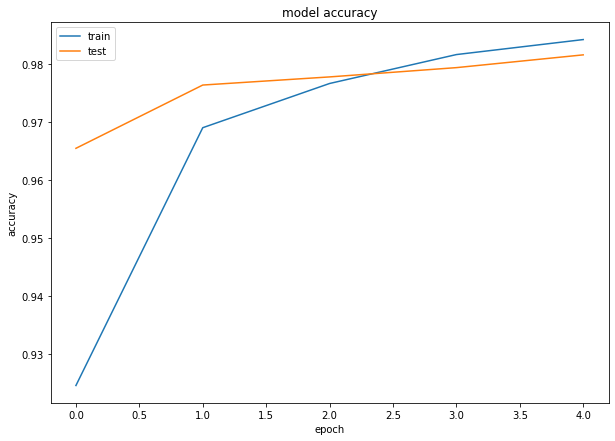

In [15]:
fig = plt.figure(figsize=(10, 7))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Une **matrice de confusion** est utilisée en Machine Learning pour tester la robustesse des algorithmes prédictifs. 

L'accuracy ou le pourcentage de bien classé pour de la classification peut être trompeur si le nombre d'observations dans chaque classe est inégal ou si il y a plus de deux classes dans le jeu de données.

Les résultats sont ensuite organisés dans un une matrice comme suit :
* En abscice vous retrouverez les classes prédites par le modèle
* En ordonné vous retrouverez les classes réelles

Les décomptes de classification correcte et incorrecte sont ensuite remplis dans le tableau en fonction des prédictions.

Vous avez en diagonal les images correctement classifiées et en dehors les erreurs de classification.

Ici la matrice de confusion a été déterminé à partir des 10,000 données de test.


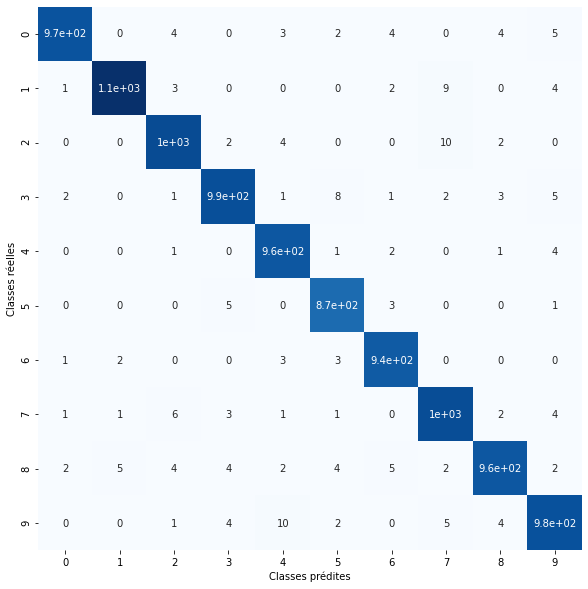

In [16]:
fig = plt.figure(figsize=(10, 10)) 

y_pred = fc_model.predict(X_test) # Prédiction du modèle sur les données test | Probabilité de distribution sur l'ensemble des classes

Y_pred = np.argmax(y_pred, 1) # Probabilité de distribution --> prédictions classes
Y_test2 = np.argmax(Y_test, 1) # Format one hot encoding --> classes réelles

mat = confusion_matrix(Y_test2, Y_pred) # Matrice de confusion à partir des vecteurs

# Affichage de la matrice de confusion
sns.heatmap(mat.T, square=True, annot=True, cbar=False, cmap=plt.cm.Blues)
plt.xlabel('Classes prédites')
plt.ylabel('Classes réelles')
plt.show()

In [17]:
# La fonction predict_classes génère la classe associé à la probabilité la plus élevée
predicted_classes = fc_model.predict_classes(X_test)

# Vérification des classes correctement classifié / mal classifié
correct_indices = np.nonzero(predicted_classes == y_test)[0]

incorrect_indices = np.nonzero(predicted_classes != y_test)[0]

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


Cas de bonnes prédictions

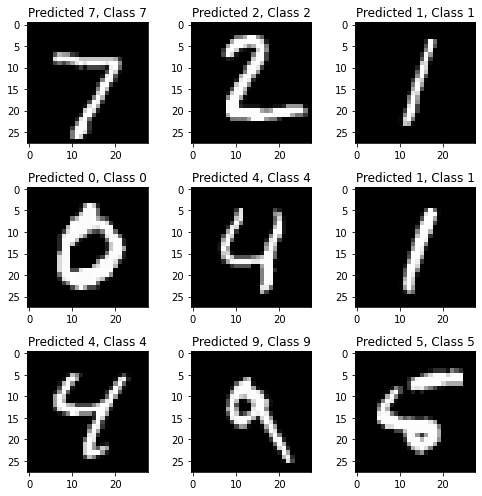

In [18]:
plt.rcParams['figure.figsize'] = (7, 7)
for i, correct in enumerate(correct_indices[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[correct].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[correct], y_test[correct]))
    
plt.tight_layout()

Cas de mauvaises prédictions

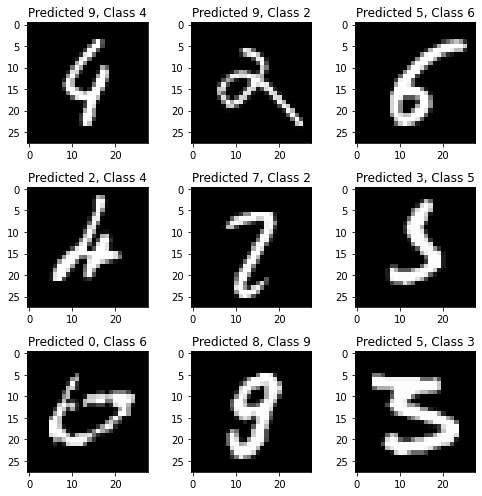

In [19]:
plt.rcParams['figure.figsize'] = (7, 7)
for i, incorrect in enumerate(incorrect_indices[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[incorrect].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[incorrect], y_test[incorrect]))
    
plt.tight_layout()

**Exercice** : Vous allez développer de nouvelles architectures en variant le nombre de couche, le nombre de neurones dans chaque couche, le batch size et le nombre d'epoch. Pour chacun des modèles développez vous reporterez l'accuracy sur les données d'entraînement et de test.

# 1er modèle developpé:

## nombre de couche =2 -> 3

## nombre de neurones=512

## batch size= 128

## nombre d'epoch= 5

In [20]:
fc_model_1 = Sequential() # creation d'un réseau neuronal

fc_model_1.add(Dense(512, input_dim=784)) #512 represente le nombre de neurones
fc_model_1.add(Activation("relu")) #relu est la fonction d'activation
fc_model_1.add(Dropout(0.2)) # dropout est introduite entre les deux couches cachées avec un taux d'abondon de 20% comme contrainte poids sur ces couches

fc_model_1.add(Dense(512)) #512 represente le nombre de neurones
fc_model_1.add(Activation("relu"))  #relu est la fonction d'activation
fc_model_1.add(Dropout(0.2))

fc_model_1.add(Dense(512)) #512 represente le nombre de neurones
fc_model_1.add(Activation("relu"))  #relu est la fonction d'activation
fc_model_1.add(Dropout(0.2))

fc_model_1.add(Dense(10)) #10 est le nombre de neurones pour la couche de sortie
fc_model_1.add(Activation("softmax")) #softmax est la fonction d'activation

In [21]:
fc_model_1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = fc_model_1.fit(
              X_train, 
              Y_train,
              validation_data=(X_test, Y_test),
              batch_size=128, 
              epochs=5,
              verbose=1
              )

Epoch 1/5
469/469 [==============================] - 10s 22ms/step - loss: 0.2544 - accuracy: 0.9217 - val_loss: 0.1111 - val_accuracy: 0.9662
Epoch 2/5
469/469 [==============================] - 10s 22ms/step - loss: 0.1104 - accuracy: 0.9669 - val_loss: 0.0938 - val_accuracy: 0.9703
Epoch 3/5
469/469 [==============================] - 10s 22ms/step - loss: 0.0825 - accuracy: 0.9752 - val_loss: 0.0773 - val_accuracy: 0.9773
Epoch 4/5
469/469 [==============================] - 10s 22ms/step - loss: 0.0646 - accuracy: 0.9799 - val_loss: 0.0737 - val_accuracy: 0.9788
Epoch 5/5
469/469 [==============================] - 10s 22ms/step - loss: 0.0537 - accuracy: 0.9831 - val_loss: 0.0812 - val_accuracy: 0.9770


In [22]:
score_train_1 = fc_model_1.evaluate(X_train,Y_train)
score_test_1 = fc_model_1.evaluate(X_test,Y_test)
print('Training accuracy:', score_train_1[1])
print('Test accuracy:', score_test_1[1])

313/313 [==============================] - 1s 4ms/step - loss: 0.0812 - accuracy: 0.9770
Training accuracy: 0.9880833625793457
Test accuracy: 0.9769999980926514


# 2eme modèle developpé:
## nombre de couche =2
## nombre de neurones=512 -> 600
## batch size= 128
## nombre d'epoch= 5

In [23]:
fc_model_2 = Sequential() # creation d'un réseau neuronal

fc_model_2.add(Dense(600, input_dim=784)) #600 represente le nombre de neurones
fc_model_2.add(Activation("relu")) #relu est la fonction d'activation
fc_model_2.add(Dropout(0.2)) # dropout est introduite entre les deux couches cachées avec un taux d'abondon de 20% comme contrainte poids sur ces couches

fc_model_2.add(Dense(600)) #600 represente le nombre de neurones
fc_model_2.add(Activation("relu"))  #relu est la fonction d'activation
fc_model_2.add(Dropout(0.2))

fc_model_2.add(Dense(10)) #10 est le nombre de neurones pour la couche de sortie
fc_model_2.add(Activation("softmax")) #softmax est la fonction d'activation

In [24]:
fc_model_2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = fc_model_2.fit(
              X_train, 
              Y_train,
              validation_data=(X_test, Y_test),
              batch_size=128, 
              epochs=5,
              verbose=1
              )

Epoch 1/5
469/469 [==============================] - 8s 18ms/step - loss: 0.2396 - accuracy: 0.9285 - val_loss: 0.1107 - val_accuracy: 0.9642
Epoch 2/5
469/469 [==============================] - 8s 17ms/step - loss: 0.0963 - accuracy: 0.9699 - val_loss: 0.0805 - val_accuracy: 0.9739
Epoch 3/5
469/469 [==============================] - 8s 18ms/step - loss: 0.0694 - accuracy: 0.9785 - val_loss: 0.0660 - val_accuracy: 0.9795
Epoch 4/5
469/469 [==============================] - 8s 18ms/step - loss: 0.0535 - accuracy: 0.9832 - val_loss: 0.0749 - val_accuracy: 0.9768
Epoch 5/5
469/469 [==============================] - 8s 18ms/step - loss: 0.0449 - accuracy: 0.9848 - val_loss: 0.0658 - val_accuracy: 0.9789


In [25]:
score_train_2 = fc_model_2.evaluate(X_train,Y_train)
score_test_2 = fc_model_2.evaluate(X_test,Y_test)
print('Training accuracy:', score_train_2[1])
print('Test accuracy:', score_test_2[1])

313/313 [==============================] - 1s 4ms/step - loss: 0.0658 - accuracy: 0.9789
Training accuracy: 0.9927166700363159
Test accuracy: 0.9789000153541565


# 3eme modèle developpé:
## nombre de couche =2
## nombre de neurones=512
## batch size= 128 -> 150
## nombre d'epoch= 5

In [26]:
fc_model_3 = Sequential() # creation d'un réseau neuronal

fc_model_3.add(Dense(512, input_dim=784)) #512 represente le nombre de neurones
fc_model_3.add(Activation("relu")) #relu est la fonction d'activation
fc_model_3.add(Dropout(0.2)) # dropout est introduite entre les deux couches cachées avec un taux d'abondon de 20% comme contrainte poids sur ces couches

fc_model_3.add(Dense(512)) #512 represente le nombre de neurones
fc_model_3.add(Activation("relu"))  #relu est la fonction d'activation
fc_model_3.add(Dropout(0.2))

fc_model_3.add(Dense(10)) #10 est le nombre de neurones pour la couche de sortie
fc_model_3.add(Activation("softmax")) #softmax est la fonction d'activation

In [27]:
fc_model_3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = fc_model_3.fit(
              X_train, 
              Y_train,
              validation_data=(X_test, Y_test),
              batch_size=150, 
              epochs=5,
              verbose=1
              )

Epoch 1/5
400/400 [==============================] - 6s 16ms/step - loss: 0.2608 - accuracy: 0.9218 - val_loss: 0.1079 - val_accuracy: 0.9656
Epoch 2/5
400/400 [==============================] - 6s 15ms/step - loss: 0.1009 - accuracy: 0.9686 - val_loss: 0.0844 - val_accuracy: 0.9726
Epoch 3/5
400/400 [==============================] - 6s 15ms/step - loss: 0.0713 - accuracy: 0.9777 - val_loss: 0.0816 - val_accuracy: 0.9740
Epoch 4/5
400/400 [==============================] - 6s 15ms/step - loss: 0.0573 - accuracy: 0.9815 - val_loss: 0.0796 - val_accuracy: 0.9747
Epoch 5/5
400/400 [==============================] - 6s 15ms/step - loss: 0.0460 - accuracy: 0.9848 - val_loss: 0.0632 - val_accuracy: 0.9808


In [28]:
score_train_3 = fc_model_3.evaluate(X_train,Y_train)
score_test_3 = fc_model_3.evaluate(X_test,Y_test)
print('Training accuracy:', score_train_3[1])
print('Test accuracy:', score_test_3[1])

313/313 [==============================] - 1s 3ms/step - loss: 0.0632 - accuracy: 0.9808
Training accuracy: 0.9936166405677795
Test accuracy: 0.9807999730110168


# 4eme modèle developpé:
## nombre de couche =2
## nombre de neurones=512
## batch size= 128
## nombre d'epoch= 5 -> 15

In [29]:
fc_model_4 = Sequential() # creation d'un réseau neuronal

fc_model_4.add(Dense(512, input_dim=784)) #512 represente le nombre de neurones
fc_model_4.add(Activation("relu")) #relu est la fonction d'activation
fc_model_4.add(Dropout(0.2)) # dropout est introduite entre les deux couches cachées avec un taux d'abondon de 20% comme contrainte poids sur ces couches

fc_model_4.add(Dense(512)) #512 represente le nombre de neurones
fc_model_4.add(Activation("relu"))  #relu est la fonction d'activation
fc_model_4.add(Dropout(0.2))

fc_model_4.add(Dense(10)) #10 est le nombre de neurones pour la couche de sortie
fc_model_4.add(Activation("softmax")) #softmax est la fonction d'activation

In [30]:
fc_model_4.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = fc_model_4.fit(
              X_train, 
              Y_train,
              validation_data=(X_test, Y_test),
              batch_size=128, 
              epochs=15,
              verbose=1
              )

Epoch 1/15
469/469 [==============================] - 7s 15ms/step - loss: 0.2475 - accuracy: 0.9269 - val_loss: 0.1053 - val_accuracy: 0.9665
Epoch 2/15
469/469 [==============================] - 7s 14ms/step - loss: 0.1029 - accuracy: 0.9683 - val_loss: 0.0843 - val_accuracy: 0.9738
Epoch 3/15
469/469 [==============================] - 7s 15ms/step - loss: 0.0715 - accuracy: 0.9776 - val_loss: 0.0695 - val_accuracy: 0.9789
Epoch 4/15
469/469 [==============================] - 7s 15ms/step - loss: 0.0559 - accuracy: 0.9821 - val_loss: 0.0750 - val_accuracy: 0.9790
Epoch 5/15
469/469 [==============================] - 7s 15ms/step - loss: 0.0452 - accuracy: 0.9853 - val_loss: 0.0646 - val_accuracy: 0.9814
Epoch 6/15
469/469 [==============================] - 7s 15ms/step - loss: 0.0395 - accuracy: 0.9872 - val_loss: 0.0702 - val_accuracy: 0.9797
Epoch 7/15
469/469 [==============================] - 7s 15ms/step - loss: 0.0325 - accuracy: 0.9893 - val_loss: 0.0733 - val_accuracy: 0.9791

In [31]:
score_train_4 = fc_model_4.evaluate(X_train,Y_train)
score_test_4 = fc_model_4.evaluate(X_test,Y_test)
print('Training accuracy:', score_train_4[1])
print('Test accuracy:', score_test_4[1])

313/313 [==============================] - 1s 3ms/step - loss: 0.0772 - accuracy: 0.9810
Training accuracy: 0.9971666932106018
Test accuracy: 0.9810000061988831


# Convolutional Neural Networks

Dans le modèle précédent, nous avons alimenté notre réseau Fully Connected avec l'ensemble des pixels normalisés d'une image donnée.

Dans cette partie, nous développerons un Convolutional Neural Networks qui est constitué de deux parties :
* Une première partie qui va apprendre à détecter des caractéristiques (courbure, bords ...) propre à chaque image.

* Une deuxième partie composé d'un réseau de neurones Fully Connected qui à partir des caractéristiques de chaque image va apprendre le lien entre les caractéristiques et les différentes classes.



<img src = 'https://www.visionatics.com.tw/img/CNN%20network.png'>

Dans l'exemple ci-dessous, l'image est représenté par une matrice 5 x 5 et le noyau est une matrice 3 x 3. Une opération basé sur un simple produit scalaire a lieu entre l'image et le noyau et la nouvelle image convoluée est générée. Chaque noyau d'un CNN apprend une caractéristique différente d'une image.

Les noyaux sont souvent utilisés dans les logiciels de retouche photo pour appliquer différents filtres.

<img src='https://miro.medium.com/max/1070/1*Zx-ZMLKab7VOCQTxdZ1OAw.gif'>

Les noyaux ou kernels sont utilisés pour capturer des caractéristiques.
Il est possible de combiner une convolution avec du **max pooling**, les éléments non pertinant de l'image (ou features map) obtenu sont retirés, ne laissant que les éléments d'intérêt, réduisant le nombre de paramètres appris et diminuant le coût de calcul.

<img src='https://computersciencewiki.org/images/8/8a/MaxpoolSample2.png'>

Il est possible d'effectué des convolutions de convolutions tant qu'il y a assez de pixels pour effectué la convolution avec un noyaux.

In [32]:
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, Flatten

In [33]:
# Rechargement de la base MNIST
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(60000, 28, 28, 1) 
X_test = X_test.reshape(10000, 28, 28, 1)

X_train = X_train.astype('float32')         
X_test = X_test.astype('float32')

X_train /= 255                                            
X_test /= 255

print("Training matrix shape", X_train.shape)
print("Testing matrix shape", X_test.shape)

# one-hot encoding
nb_classes = 10 

Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

Training matrix shape (60000, 28, 28, 1)
Testing matrix shape (10000, 28, 28, 1)


**Exercice** : Implémentez un Convolutional Neural Networks composé de 3 convolutions suivi d'une couche caché composé de 512 neurones et d'une couche de sortie composé de 10 neurones. Suivez les consignes présent dans les commentaires ci-dessous.

_CONV2D -> ReLU -> DROPOUT -> CONV2D -> ReLU -> MAXPOOL -> DROPOUT -> CONV2D -> ReLU -> MAXPOOL -> DROPOUT -> FLATTEN -> FULLYCONNECTED_



In [34]:
cnn_model = Sequential()   
### START CODE HERE ### (approx. 12 lines)
# Conv2D : 32 filtres, filtre de dimension 3 x 3, activation ReLU, input_shape=(28, 28, 1)
cnn_model.add(Conv2D(32,(3,3), activation='relu', input_shape=(28, 28, 1)))
#DROPOUT : rate=0.2
cnn_model.add(Dropout(0.2)) 
# Conv2D : 32 filtres, filtre de dimension 3 x 3, activation ReLU
cnn_model.add(Conv2D(32,(3,3), activation='relu'))      
# Max Pooling : pool_size=(2,2)
cnn_model.add(MaxPooling2D(pool_size=(2,2)))           
# DROPOUT : rate=0.2
cnn_model.add(Dropout(0.2))
# Conv2D : 64 filtres, filtre de dimension 3 x 3, activation ReLU
cnn_model.add(Conv2D(64,(3,3), activation='relu'))
# Max Pooling : pool_size=(2,2)
cnn_model.add(MaxPooling2D(pool_size=(2,2)))   
# DROPOUT : rate=0.2
cnn_model.add(Dropout(0.2))
# Flatten
cnn_model.add(Flatten())
# DENSE : 512, activation ReLU
cnn_model.add(Dense(512))
cnn_model.add(Activation('relu'))
# Dropout : rate=0.2
cnn_model.add(Dropout(0.2))
# DENSE : 10 neurones (10 classes), activation Softmax
cnn_model.add(Dense(10))
cnn_model.add(Activation('softmax'))
### END CODE HERE ###  

cnn_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
dropout_11 (Dropout)         (None, 26, 26, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)         

**Exercice** : Explicitez le calcul du nombre de paramètres du modèle.

# Solution:

(Convolution kernel length * Convolution kernel width * Number of channels + 1) * Number of convolution kernels

- conv2d_6 (Conv2D)=320: (3 * 3 * 1 + 1) * 32

- dropout_18 (Dropout)= 0 : cette couche n'apprend pas

- conv2d_7 (Conv2D)= 9248 : (3 * 3 * 32 + 1) * 32

- max_pooling2d_4 (MaxPooling2)= 0: cette couche n'apprend pas

- dropout_19=0 : cette couche n'apprend pas

- conv2d_8 (Conv2D)= 18496: (3 * 3 * 32 + 1) *64

- max_pooling2d_5 (MaxPooling2)=0: cette couche n'apprend pas

- dropout_20 (Dropout)=0 : cette couche n'apprend pas

- flatten_2 (Flatten)=0 :cette couche n'apprend pas

- dense_19 (Dense)= 819712: 512 * (1600 + 1) = 819712

- activation_17 (Activation) =0 :cette couche n'apprend pas

- dropout_21 (Dropout)=0 : cette couche n'apprend pas

- dense_20 (Dense)=5130 : 512* 10 (number of classes) + 10 (number of classes)

- activation_18 (Activation)=0 : cette couche n'apprend pas

In [35]:
cnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

L'augmentation de données est une technique très populaire en Machine Learning qui peut être utilisée pour augmenter artificiellement la taille d'un ensemble de données d'entraînement en créant des versions modifiées des images.

L'entraînement des modèles de Deep Learning sur plus de données peut aboutir à des modèles plus performant, et les techniques d'augmentation de données peuvent créer des variantes des images qui peuvent améliorer la capacité de généralisation des modèles.

La bibliothèque Keras offre la possibilité d'utilisé l'augmentation de données via la classe ImageDataGenerator.

* Ceci étant particulièrement utile pour les petits ensembles de données 
* [Plus de détails](http://cs231n.stanford.edu/reports/2017/pdfs/300.pdf) 

Documentation : https://keras.io/preprocessing/image/

In [36]:
gen = ImageDataGenerator(rotation_range=8, width_shift_range=0.08, shear_range=0.3,
                         height_shift_range=0.08, zoom_range=0.08)

test_gen = ImageDataGenerator()

In [37]:
train_generator = gen.flow(X_train, Y_train, batch_size=128)
test_generator = test_gen.flow(X_test, Y_test, batch_size=128)

In [38]:
cnn_model.fit_generator(train_generator, steps_per_epoch=60000//128, epochs=5, verbose=1, 
                    validation_data=test_generator, validation_steps=10000//128)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/5
468/468 [==============================] - 126s 269ms/step - loss: 0.3135 - accuracy: 0.8991 - val_loss: 0.0413 - val_accuracy: 0.9859
Epoch 2/5
468/468 [==============================] - 126s 270ms/step - loss: 0.0960 - accuracy: 0.9700 - val_loss: 0.0264 - val_accuracy: 0.9924
Epoch 3/5
468/468 [==============================] - 128s 274ms/step - loss: 0.0704 - accuracy: 0.9779 - val_loss: 0.0201 - val_accuracy: 0.9940
Epoch 4/5
468/468 [==============================] - 123s 264ms/step - loss: 0.0587 - accuracy: 0.9815 - val_loss: 0.0231 - val_accuracy: 0.9922
Epoch 5/5
468/468 [==============================] - 123s 263ms/step - loss: 0.0528 - accuracy: 0.9836 - val_loss: 0.0253 - val_accuracy: 0.9917


In [39]:
score = cnn_model.evaluate(X_test, Y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 5s 15ms/step - loss: 0.0252 - accuracy: 0.9917
Test score: 0.02521304413676262
Test accuracy: 0.9916999936103821


**Exercice** :  Vous allez développer de nouvelles architectures CNN en variant le nombre de convolution, le nombre de filtre, la taille des filtres, le batch size et le nombre d'epoch. Pour chacun des modèles développez vous reporterez l'accuracy sur les données d'entraînement et de test.

# Solution:

# Effets de variation du nombre de convolution:
## nombre de convolution =3 -> 4
## nombre de filtre=32
## Taille des filtres = 3x3
## batch size = 128
## nombre d'epoch =5

In [40]:
cnn_model = Sequential()   
### START CODE HERE ### (approx. 12 lines)


# Conv2D : 32 filtres, filtre de dimension 3 x 3, activation ReLU, input_shape=(28, 28, 1)
cnn_model.add(Conv2D(32,(3,3), activation='relu', input_shape=(28, 28, 1)))
#DROPOUT : rate=0.2
cnn_model.add(Dropout(0.2)) 


# Conv2D : 32 filtres, filtre de dimension 3 x 3, activation ReLU
cnn_model.add(Conv2D(32,(3,3), activation='relu'))      
# Max Pooling : pool_size=(2,2)
cnn_model.add(MaxPooling2D(pool_size=(2,2)))           
# DROPOUT : rate=0.2
cnn_model.add(Dropout(0.2))

# Conv2D : 32 filtres, filtre de dimension 3 x 3, activation ReLU
cnn_model.add(Conv2D(32,(3,3), activation='relu'))
# Max Pooling : pool_size=(2,2)
cnn_model.add(MaxPooling2D(pool_size=(2,2)))   
# DROPOUT : rate=0.2
cnn_model.add(Dropout(0.2))

# Conv2D : 64 filtres, filtre de dimension 3 x 3, activation ReLU
cnn_model.add(Conv2D(64,(3,3), activation='relu'))
# Max Pooling : pool_size=(2,2)
cnn_model.add(MaxPooling2D(pool_size=(2,2)))   
# DROPOUT : rate=0.2
cnn_model.add(Dropout(0.2))


# Flatten
cnn_model.add(Flatten())
# DENSE : 512, activation ReLU
cnn_model.add(Dense(512))
cnn_model.add(Activation('relu'))
# Dropout : rate=0.2
cnn_model.add(Dropout(0.2))

# DENSE : 10 neurones (10 classes), activation Softmax
cnn_model.add(Dense(10))
cnn_model.add(Activation('softmax'))
### END CODE HERE ###  

cnn_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
dropout_15 (Dropout)         (None, 26, 26, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 10, 10, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 32)         

In [41]:
cnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [42]:
gen = ImageDataGenerator(rotation_range=8, width_shift_range=0.08, shear_range=0.3,
                         height_shift_range=0.08, zoom_range=0.08)

test_gen = ImageDataGenerator()

In [43]:
train_generator = gen.flow(X_train, Y_train, batch_size=128)
test_generator = test_gen.flow(X_test, Y_test, batch_size=128)

In [44]:
cnn_model.fit_generator(train_generator, steps_per_epoch=60000//128, epochs=5, verbose=1, validation_data=test_generator, validation_steps=10000//128)

Epoch 1/5
468/468 [==============================] - 113s 242ms/step - loss: 0.6544 - accuracy: 0.7840 - val_loss: 0.0984 - val_accuracy: 0.9701
Epoch 2/5
468/468 [==============================] - 113s 241ms/step - loss: 0.2319 - accuracy: 0.9283 - val_loss: 0.0547 - val_accuracy: 0.9837
Epoch 3/5
468/468 [==============================] - 112s 240ms/step - loss: 0.1688 - accuracy: 0.9479 - val_loss: 0.0527 - val_accuracy: 0.9842
Epoch 4/5
468/468 [==============================] - 113s 240ms/step - loss: 0.1375 - accuracy: 0.9589 - val_loss: 0.0385 - val_accuracy: 0.9885
Epoch 5/5
468/468 [==============================] - 114s 244ms/step - loss: 0.1192 - accuracy: 0.9630 - val_loss: 0.0345 - val_accuracy: 0.9895


In [45]:
score = cnn_model.evaluate(X_test, Y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 4s 13ms/step - loss: 0.0344 - accuracy: 0.9895
Test score: 0.034425314515829086
Test accuracy: 0.9894999861717224


# Effets de variation du nombre de filtre:
## nombre de convolution =3
## nombre de filtre=32 -> 64
## Taille des filtres = 3x3
## batch size = 128
## nombre d'epoch =5

In [46]:
cnn_model = Sequential()   
### START CODE HERE ### (approx. 12 lines)
# Conv2D : 32 filtres, filtre de dimension 3 x 3, activation ReLU, input_shape=(28, 28, 1)
cnn_model.add(Conv2D(32,(3,3), activation='relu', input_shape=(28, 28, 1)))
#DROPOUT : rate=0.2
cnn_model.add(Dropout(0.2)) 
# Conv2D : 64 filtres, filtre de dimension 3 x 3, activation ReLU
cnn_model.add(Conv2D(64,(3,3), activation='relu'))      
# Max Pooling : pool_size=(2,2)
cnn_model.add(MaxPooling2D(pool_size=(2,2)))           
# DROPOUT : rate=0.2
cnn_model.add(Dropout(0.2))
# Conv2D : 128 filtres, filtre de dimension 3 x 3, activation ReLU
cnn_model.add(Conv2D(128,(3,3), activation='relu'))
# Max Pooling : pool_size=(2,2)
cnn_model.add(MaxPooling2D(pool_size=(2,2)))   
# DROPOUT : rate=0.2
cnn_model.add(Dropout(0.2))

# Flatten
cnn_model.add(Flatten())
# DENSE : 512, activation ReLU
cnn_model.add(Dense(512))
cnn_model.add(Activation('relu'))
# Dropout : rate=0.2
cnn_model.add(Dropout(0.2))

# DENSE : 10 neurones (10 classes), activation Softmax
cnn_model.add(Dense(10))
cnn_model.add(Activation('softmax'))
### END CODE HERE ###  

cnn_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
dropout_20 (Dropout)         (None, 26, 26, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 10, 10, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 5, 5, 128)        

In [47]:
cnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [48]:
gen = ImageDataGenerator(rotation_range=8, width_shift_range=0.08, shear_range=0.3,
                         height_shift_range=0.08, zoom_range=0.08)

test_gen = ImageDataGenerator()

In [49]:
train_generator = gen.flow(X_train, Y_train, batch_size=128)
test_generator = test_gen.flow(X_test, Y_test, batch_size=128)

In [50]:
cnn_model.fit_generator(train_generator, steps_per_epoch=60000//128, epochs=5, verbose=1, validation_data=test_generator, validation_steps=10000//128)

Epoch 1/5
468/468 [==============================] - 189s 405ms/step - loss: 0.2553 - accuracy: 0.9175 - val_loss: 0.0322 - val_accuracy: 0.9886
Epoch 2/5
468/468 [==============================] - 194s 415ms/step - loss: 0.0797 - accuracy: 0.9756 - val_loss: 0.0273 - val_accuracy: 0.9911
Epoch 3/5
468/468 [==============================] - 193s 412ms/step - loss: 0.0596 - accuracy: 0.9815 - val_loss: 0.0198 - val_accuracy: 0.9936
Epoch 4/5
468/468 [==============================] - 187s 399ms/step - loss: 0.0498 - accuracy: 0.9848 - val_loss: 0.0199 - val_accuracy: 0.9937
Epoch 5/5
468/468 [==============================] - 185s 395ms/step - loss: 0.0432 - accuracy: 0.9864 - val_loss: 0.0198 - val_accuracy: 0.9926


In [51]:
score = cnn_model.evaluate(X_test, Y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 8s 25ms/step - loss: 0.0197 - accuracy: 0.9926
Test score: 0.019722359254956245
Test accuracy: 0.9926000237464905


# Effets de variation de la taille des filtres:
## nombre de convolution =3
## nombre de filtre=32
## Taille des filtres = 3x3 -> 5x5
## batch size = 128
## nombre d'epoch =5

In [52]:
cnn_model = Sequential()   
### START CODE HERE ### (approx. 12 lines)
# Conv2D : 32 filtres, filtre de dimension 3 x 3, activation ReLU, input_shape=(28, 28, 1)
cnn_model.add(Conv2D(32,(5,5), activation='relu', input_shape=(28, 28, 1)))
#DROPOUT : rate=0.2
cnn_model.add(Dropout(0.2)) 
# Conv2D : 32 filtres, filtre de dimension 3 x 3, activation ReLU
cnn_model.add(Conv2D(32,(5,5), activation='relu'))      
# Max Pooling : pool_size=(2,2)
cnn_model.add(MaxPooling2D(pool_size=(2,2)))           
# DROPOUT : rate=0.2
cnn_model.add(Dropout(0.2))
# Conv2D : 64 filtres, filtre de dimension 3 x 3, activation ReLU
cnn_model.add(Conv2D(64,(5,5), activation='relu'))
# Max Pooling : pool_size=(2,2)
cnn_model.add(MaxPooling2D(pool_size=(2,2)))   
# DROPOUT : rate=0.2
cnn_model.add(Dropout(0.2))

# Flatten
cnn_model.add(Flatten())
# DENSE : 512, activation ReLU
cnn_model.add(Dense(512))
cnn_model.add(Activation('relu'))
# Dropout : rate=0.2
cnn_model.add(Dropout(0.2))

# DENSE : 10 neurones (10 classes), activation Softmax
cnn_model.add(Dense(10))
cnn_model.add(Activation('softmax'))
### END CODE HERE ###  

cnn_model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 24, 24, 32)        832       
_________________________________________________________________
dropout_24 (Dropout)         (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 20, 20, 32)        25632     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 10, 10, 32)        0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 10, 10, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 6, 6, 64)          51264     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 3, 3, 64)         

In [53]:
cnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [54]:
gen = ImageDataGenerator(rotation_range=8, width_shift_range=0.08, shear_range=0.3,
                         height_shift_range=0.08, zoom_range=0.08)

test_gen = ImageDataGenerator()

In [55]:
train_generator = gen.flow(X_train, Y_train, batch_size=128)
test_generator = test_gen.flow(X_test, Y_test, batch_size=128)

In [56]:
cnn_model.fit_generator(train_generator, steps_per_epoch=60000//128, epochs=5, verbose=1, validation_data=test_generator, validation_steps=10000//128)

Epoch 1/5
468/468 [==============================] - 157s 336ms/step - loss: 0.3332 - accuracy: 0.8937 - val_loss: 0.0416 - val_accuracy: 0.9857
Epoch 2/5
468/468 [==============================] - 159s 339ms/step - loss: 0.1005 - accuracy: 0.9693 - val_loss: 0.0303 - val_accuracy: 0.9900
Epoch 3/5
468/468 [==============================] - 157s 336ms/step - loss: 0.0712 - accuracy: 0.9782 - val_loss: 0.0217 - val_accuracy: 0.9929
Epoch 4/5
468/468 [==============================] - 156s 333ms/step - loss: 0.0595 - accuracy: 0.9817 - val_loss: 0.0227 - val_accuracy: 0.9927
Epoch 5/5
468/468 [==============================] - 152s 325ms/step - loss: 0.0528 - accuracy: 0.9836 - val_loss: 0.0165 - val_accuracy: 0.9950


In [57]:
score = cnn_model.evaluate(X_test, Y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 7s 22ms/step - loss: 0.0165 - accuracy: 0.9950
Test score: 0.016472890973091125
Test accuracy: 0.9950000047683716


# Effets de batch size:
## nombre de convolution =3
## nombre de filtre=32
## Taille des filtres = 3x3
## batch size = 128 -> 160
## nombre d'epoch =5

In [58]:
cnn_model = Sequential()   
### START CODE HERE ### (approx. 12 lines)
# Conv2D : 32 filtres, filtre de dimension 3 x 3, activation ReLU, input_shape=(28, 28, 1)
cnn_model.add(Conv2D(32,(3,3), activation='relu', input_shape=(28, 28, 1)))
#DROPOUT : rate=0.2
cnn_model.add(Dropout(0.2)) 
# Conv2D : 32 filtres, filtre de dimension 3 x 3, activation ReLU
cnn_model.add(Conv2D(32,(3,3), activation='relu'))      
# Max Pooling : pool_size=(2,2)
cnn_model.add(MaxPooling2D(pool_size=(2,2)))           
# DROPOUT : rate=0.2
cnn_model.add(Dropout(0.2))
# Conv2D : 64 filtres, filtre de dimension 3 x 3, activation ReLU
cnn_model.add(Conv2D(64,(3,3), activation='relu'))
# Max Pooling : pool_size=(2,2)
cnn_model.add(MaxPooling2D(pool_size=(2,2)))   
# DROPOUT : rate=0.2
cnn_model.add(Dropout(0.2))

# Flatten
cnn_model.add(Flatten())
# DENSE : 512, activation ReLU
cnn_model.add(Dense(512))
cnn_model.add(Activation('relu'))
# Dropout : rate=0.2
cnn_model.add(Dropout(0.2))

# DENSE : 10 neurones (10 classes), activation Softmax
cnn_model.add(Dense(10))
cnn_model.add(Activation('softmax'))
### END CODE HERE ###  

cnn_model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
dropout_28 (Dropout)         (None, 26, 26, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_29 (Dropout)         (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 10, 10, 64)        18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 5, 5, 64)         

In [59]:
cnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [60]:
gen = ImageDataGenerator(rotation_range=8, width_shift_range=0.08, shear_range=0.3,
                         height_shift_range=0.08, zoom_range=0.08)

test_gen = ImageDataGenerator()

In [61]:
train_generator = gen.flow(X_train, Y_train, batch_size=160)
test_generator = test_gen.flow(X_test, Y_test, batch_size=128)

In [62]:
cnn_model.fit_generator(train_generator, steps_per_epoch=60000//160, epochs=5, verbose=1, validation_data=test_generator, validation_steps=10000//160)

Epoch 1/5
375/375 [==============================] - 126s 337ms/step - loss: 0.3475 - accuracy: 0.8892 - val_loss: 0.0416 - val_accuracy: 0.9880
Epoch 2/5
375/375 [==============================] - 125s 334ms/step - loss: 0.1046 - accuracy: 0.9673 - val_loss: 0.0353 - val_accuracy: 0.9884
Epoch 3/5
375/375 [==============================] - 125s 334ms/step - loss: 0.0756 - accuracy: 0.9769 - val_loss: 0.0240 - val_accuracy: 0.9921
Epoch 4/5
375/375 [==============================] - 125s 334ms/step - loss: 0.0623 - accuracy: 0.9808 - val_loss: 0.0205 - val_accuracy: 0.9927
Epoch 5/5
375/375 [==============================] - 126s 336ms/step - loss: 0.0568 - accuracy: 0.9822 - val_loss: 0.0193 - val_accuracy: 0.9937


In [63]:
score = cnn_model.evaluate(X_test, Y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 5s 16ms/step - loss: 0.0190 - accuracy: 0.9938
Test score: 0.01902044005692005
Test accuracy: 0.9937999844551086


# Effets du nombre d'epoch:
## nombre de convolution =3
## nombre de filtre=32
## Taille des filtres = 3x3
## batch size = 128
## nombre d'epoch =5 - > 10

In [64]:
cnn_model = Sequential()   
### START CODE HERE ### (approx. 12 lines)
# Conv2D : 32 filtres, filtre de dimension 3 x 3, activation ReLU, input_shape=(28, 28, 1)
cnn_model.add(Conv2D(32,(3,3), activation='relu', input_shape=(28, 28, 1)))
#DROPOUT : rate=0.2
cnn_model.add(Dropout(0.2)) 
# Conv2D : 32 filtres, filtre de dimension 3 x 3, activation ReLU
cnn_model.add(Conv2D(32,(3,3), activation='relu'))      
# Max Pooling : pool_size=(2,2)
cnn_model.add(MaxPooling2D(pool_size=(2,2)))           
# DROPOUT : rate=0.2
cnn_model.add(Dropout(0.2))
# Conv2D : 64 filtres, filtre de dimension 3 x 3, activation ReLU
cnn_model.add(Conv2D(64,(3,3), activation='relu'))
# Max Pooling : pool_size=(2,2)
cnn_model.add(MaxPooling2D(pool_size=(2,2)))   
# DROPOUT : rate=0.2
cnn_model.add(Dropout(0.2))

# Flatten
cnn_model.add(Flatten())
# DENSE : 512, activation ReLU
cnn_model.add(Dense(512))
cnn_model.add(Activation('relu'))
# Dropout : rate=0.2
cnn_model.add(Dropout(0.2))

# DENSE : 10 neurones (10 classes), activation Softmax
cnn_model.add(Dense(10))
cnn_model.add(Activation('softmax'))
### END CODE HERE ###  

cnn_model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
dropout_32 (Dropout)         (None, 26, 26, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_33 (Dropout)         (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 10, 10, 64)        18496     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 5, 5, 64)        

In [65]:
cnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [66]:
gen = ImageDataGenerator(rotation_range=8, width_shift_range=0.08, shear_range=0.3,
                         height_shift_range=0.08, zoom_range=0.08)

test_gen = ImageDataGenerator()

In [67]:
train_generator = gen.flow(X_train, Y_train, batch_size=128)
test_generator = test_gen.flow(X_test, Y_test, batch_size=128)

In [68]:
cnn_model.fit_generator(train_generator, steps_per_epoch=60000//128, epochs=10, verbose=1, validation_data=test_generator, validation_steps=10000//128)

Epoch 1/10
468/468 [==============================] - 129s 275ms/step - loss: 0.3225 - accuracy: 0.8974 - val_loss: 0.0409 - val_accuracy: 0.9854
Epoch 2/10
468/468 [==============================] - 129s 277ms/step - loss: 0.0959 - accuracy: 0.9706 - val_loss: 0.0267 - val_accuracy: 0.9911
Epoch 3/10
468/468 [==============================] - 132s 281ms/step - loss: 0.0689 - accuracy: 0.9787 - val_loss: 0.0228 - val_accuracy: 0.9920
Epoch 4/10
468/468 [==============================] - 128s 274ms/step - loss: 0.0593 - accuracy: 0.9809 - val_loss: 0.0167 - val_accuracy: 0.9939
Epoch 5/10
468/468 [==============================] - 130s 277ms/step - loss: 0.0517 - accuracy: 0.9840 - val_loss: 0.0167 - val_accuracy: 0.9939
Epoch 6/10
468/468 [==============================] - 129s 275ms/step - loss: 0.0453 - accuracy: 0.9857 - val_loss: 0.0148 - val_accuracy: 0.9952
Epoch 7/10
468/468 [==============================] - 128s 273ms/step - loss: 0.0412 - accuracy: 0.9867 - val_loss: 0.0188 -

In [69]:
score = cnn_model.evaluate(X_test, Y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 5s 16ms/step - loss: 0.0150 - accuracy: 0.9950
Test score: 0.014997969381511211
Test accuracy: 0.9950000047683716


# Transfer Learning

Le Transfer Learning est une technique qui permet d'utiliser un modèle de Deep Learning déjà entraîner à apprendre une tâche à apprendre une nouvelle tâche.

Généralement on utilise un modèle pré-entraîner quand le jeu de données d'entraînement est limité en taille (il est primordial en général d'avoir un jeu de données conséquant en taille pour entraîner des algorithmes de Deep Learning). Un autre avantage est le temps de ré-entraînement du modèle à partir des nouvelles données.

Les humains ont une capacité inhérente à transférer des connaissances entre des tâches. Ce que nous apprenons sur une tâche peut être utilisé pour des tâches connexes. Plus les tâches sont proche plus il sera facile plus le transfer sera facile/rapide.

<img src='https://blog.superannotate.com/hs-fs/hubfs/Speed%20up%20the%20labeling%20process%20using%20transfer%20learning%201.png?width=1600&name=Speed%20up%20the%20labeling%20process%20using%20transfer%20learning%201.png'>

<img src='https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2017/09/Three-ways-in-which-transfer-might-improve-learning.png' width="600"/>

<img src='https://neurohive.io/wp-content/uploads/2019/01/resnet-e1548261477164.png' width='400'/>

In [70]:
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.models import Model
import cv2

In [71]:
# Rechargement de la base MNIST
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(60000, 28, 28, 1) 
X_test = X_test.reshape(10000, 28, 28, 1)

X_train = X_train.astype('float32')         
X_test = X_test.astype('float32')

X_train /= 255                                            
X_test /= 255

# one-hot encoding
nb_classes = 10 

Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

trainX = [cv2.resize(cv2.cvtColor(X_train[i], cv2.COLOR_GRAY2RGB), dsize=(32,32)) for i in range(len(X_train))]
trainX = np.array(trainX)

testX = [cv2.resize(cv2.cvtColor(X_test[i], cv2.COLOR_GRAY2RGB), dsize=(32,32)) for i in range(len(X_test))]
testX = np.array(testX)

print("Dimension trainX : ", trainX.shape)
print("Dimension y_train : ", y_train.shape)
print("Dimension testX : ", testX.shape)
print("Dimension y_test : ", y_test.shape)

Dimension trainX :  (60000, 32, 32, 3)
Dimension y_train :  (60000,)
Dimension testX :  (10000, 32, 32, 3)
Dimension y_test :  (10000,)


In [72]:
# Chargement du modèle pré-entraîner ResNet50 sans la partie Fully Connected
model = ResNet50(include_top=False, weights='imagenet', pooling='max', input_shape=(32, 32, 3))

In [73]:
# Marquer les couches du modèles non entrainable (Convolutions)
for layer in model.layers:
    layer.trainable = False
  
# Ajout d'une couche Fully Connected
y=model.layers[-1]
x = Dense(512, activation='relu')(y.output)

# Ajout d'une couche de sortie
output = Dense(10, activation='softmax')(x)
# define new model
model = Model(inputs=model.inputs, outputs=output)
# summarize
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 16, 16, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 16, 16, 64)   256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [74]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [75]:
model.fit(trainX, 
          Y_train,
          validation_data=(testX, Y_test),
          batch_size=64, 
          epochs=5,
          verbose=1
          )

Epoch 1/5
938/938 [==============================] - 229s 244ms/step - loss: 0.5660 - accuracy: 0.8215 - val_loss: 0.3096 - val_accuracy: 0.9021
Epoch 2/5
938/938 [==============================] - 241s 257ms/step - loss: 0.3265 - accuracy: 0.8949 - val_loss: 0.2449 - val_accuracy: 0.9218
Epoch 3/5
938/938 [==============================] - 240s 255ms/step - loss: 0.2790 - accuracy: 0.9101 - val_loss: 0.2339 - val_accuracy: 0.9259
Epoch 4/5
938/938 [==============================] - 238s 254ms/step - loss: 0.2538 - accuracy: 0.9175 - val_loss: 0.2047 - val_accuracy: 0.9333
Epoch 5/5
938/938 [==============================] - 237s 252ms/step - loss: 0.2350 - accuracy: 0.9252 - val_loss: 0.2187 - val_accuracy: 0.9335


**Exercice** : Vous ferez varier ici la partie fully connect (nombre de hidden layer, de neurones), le batch size et le nombre d'epoch. Vous reporterez l'accuracy sur les données d'entraînement et de test de chaque architecture développé.

# Solution: effet de nombre de hidden layer:
### nombre de hidden layer: 1 -> 2
### nombre de neurones: 512
### batch size: 64
### nombre d'epoch: 5 

In [76]:
# Rechargement de la base MNIST
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(60000, 28, 28, 1) 
X_test = X_test.reshape(10000, 28, 28, 1)

X_train = X_train.astype('float32')         
X_test = X_test.astype('float32')

X_train /= 255                                            
X_test /= 255

# one-hot encoding
nb_classes = 10 

Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

trainX = [cv2.resize(cv2.cvtColor(X_train[i], cv2.COLOR_GRAY2RGB), dsize=(32,32)) for i in range(len(X_train))]
trainX = np.array(trainX)

testX = [cv2.resize(cv2.cvtColor(X_test[i], cv2.COLOR_GRAY2RGB), dsize=(32,32)) for i in range(len(X_test))]
testX = np.array(testX)

print("Dimension trainX : ", trainX.shape)
print("Dimension y_train : ", y_train.shape)
print("Dimension testX : ", testX.shape)
print("Dimension y_test : ", y_test.shape)

Dimension trainX :  (60000, 32, 32, 3)
Dimension y_train :  (60000,)
Dimension testX :  (10000, 32, 32, 3)
Dimension y_test :  (10000,)


In [77]:
# Chargement du modèle pré-entraîner ResNet50 sans la partie Fully Connected
model = ResNet50(include_top=False, weights='imagenet', pooling='max', input_shape=(32, 32, 3))

In [78]:
# Marquer les couches du modèles non entrainable (Convolutions)
for layer in model.layers:
    layer.trainable = False
  
# Ajout d'une couche Fully Connected
y=model.layers[-1]
x = Dense(512, activation='relu')(y.output)
x = Dense(512, activation='relu')(y.output) ##--------------------------

# Ajout d'une couche de sortie
output = Dense(10, activation='softmax')(x)
# define new model
model = Model(inputs=model.inputs, outputs=output)
# summarize
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 3)    0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 16, 16, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 16, 16, 64)   256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [79]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [80]:
model.fit(trainX, 
          Y_train,
          validation_data=(testX, Y_test),
          batch_size=64, 
          epochs=5,
          verbose=1
          )

Epoch 1/5
938/938 [==============================] - 229s 244ms/step - loss: 0.5600 - accuracy: 0.8235 - val_loss: 0.3117 - val_accuracy: 0.9035
Epoch 2/5
938/938 [==============================] - 242s 258ms/step - loss: 0.3220 - accuracy: 0.8961 - val_loss: 0.2429 - val_accuracy: 0.9219
Epoch 3/5
938/938 [==============================] - 242s 258ms/step - loss: 0.2787 - accuracy: 0.9089 - val_loss: 0.2084 - val_accuracy: 0.9345
Epoch 4/5
938/938 [==============================] - 235s 251ms/step - loss: 0.2553 - accuracy: 0.9182 - val_loss: 0.2250 - val_accuracy: 0.9292
Epoch 5/5
938/938 [==============================] - 236s 251ms/step - loss: 0.2375 - accuracy: 0.9230 - val_loss: 0.2067 - val_accuracy: 0.9315


# Solution: effet de nombre de neurones:
### nombre de hidden layer: 1 
### nombre de neurones: 512 ->256
### batch size: 64
### nombre d'epoch: 5 

In [81]:
# Rechargement de la base MNIST
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(60000, 28, 28, 1) 
X_test = X_test.reshape(10000, 28, 28, 1)

X_train = X_train.astype('float32')         
X_test = X_test.astype('float32')

X_train /= 255                                            
X_test /= 255

# one-hot encoding
nb_classes = 10 

Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

trainX = [cv2.resize(cv2.cvtColor(X_train[i], cv2.COLOR_GRAY2RGB), dsize=(32,32)) for i in range(len(X_train))]
trainX = np.array(trainX)

testX = [cv2.resize(cv2.cvtColor(X_test[i], cv2.COLOR_GRAY2RGB), dsize=(32,32)) for i in range(len(X_test))]
testX = np.array(testX)

print("Dimension trainX : ", trainX.shape)
print("Dimension y_train : ", y_train.shape)
print("Dimension testX : ", testX.shape)
print("Dimension y_test : ", y_test.shape)

Dimension trainX :  (60000, 32, 32, 3)
Dimension y_train :  (60000,)
Dimension testX :  (10000, 32, 32, 3)
Dimension y_test :  (10000,)


In [82]:
# Chargement du modèle pré-entraîner ResNet50 sans la partie Fully Connected
model = ResNet50(include_top=False, weights='imagenet', pooling='max', input_shape=(32, 32, 3))

In [83]:
# Marquer les couches du modèles non entrainable (Convolutions)
for layer in model.layers:
    layer.trainable = False
  
# Ajout d'une couche Fully Connected
y=model.layers[-1]
x = Dense(256, activation='relu')(y.output)

# Ajout d'une couche de sortie
output = Dense(10, activation='softmax')(x)
# define new model
model = Model(inputs=model.inputs, outputs=output)
# summarize
model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 3)    0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 16, 16, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 16, 16, 64)   256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [84]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [85]:
model.fit(trainX, 
          Y_train,
          validation_data=(testX, Y_test),
          batch_size=64, 
          epochs=5,
          verbose=1
          )

Epoch 1/5
938/938 [==============================] - 228s 243ms/step - loss: 0.5765 - accuracy: 0.8207 - val_loss: 0.3425 - val_accuracy: 0.8915
Epoch 2/5
938/938 [==============================] - 233s 248ms/step - loss: 0.3277 - accuracy: 0.8943 - val_loss: 0.3033 - val_accuracy: 0.9038
Epoch 3/5
938/938 [==============================] - 229s 244ms/step - loss: 0.2838 - accuracy: 0.9093 - val_loss: 0.2259 - val_accuracy: 0.9286
Epoch 4/5
938/938 [==============================] - 224s 239ms/step - loss: 0.2577 - accuracy: 0.9175 - val_loss: 0.2131 - val_accuracy: 0.9303
Epoch 5/5
938/938 [==============================] - 225s 240ms/step - loss: 0.2377 - accuracy: 0.9230 - val_loss: 0.1966 - val_accuracy: 0.9369


# Solution: effet de batch size:
### nombre de hidden layer: 1 
### nombre de neurones: 512
### batch size: 64 ->128
### nombre d'epoch: 5 

In [86]:
# Rechargement de la base MNIST
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(60000, 28, 28, 1) 
X_test = X_test.reshape(10000, 28, 28, 1)

X_train = X_train.astype('float32')         
X_test = X_test.astype('float32')

X_train /= 255                                            
X_test /= 255

# one-hot encoding
nb_classes = 10 

Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

trainX = [cv2.resize(cv2.cvtColor(X_train[i], cv2.COLOR_GRAY2RGB), dsize=(32,32)) for i in range(len(X_train))]
trainX = np.array(trainX)

testX = [cv2.resize(cv2.cvtColor(X_test[i], cv2.COLOR_GRAY2RGB), dsize=(32,32)) for i in range(len(X_test))]
testX = np.array(testX)

print("Dimension trainX : ", trainX.shape)
print("Dimension y_train : ", y_train.shape)
print("Dimension testX : ", testX.shape)
print("Dimension y_test : ", y_test.shape)

Dimension trainX :  (60000, 32, 32, 3)
Dimension y_train :  (60000,)
Dimension testX :  (10000, 32, 32, 3)
Dimension y_test :  (10000,)


In [87]:
# Chargement du modèle pré-entraîner ResNet50 sans la partie Fully Connected
model = ResNet50(include_top=False, weights='imagenet', pooling='max', input_shape=(32, 32, 3))

In [88]:
# Marquer les couches du modèles non entrainable (Convolutions)
for layer in model.layers:
    layer.trainable = False
  
# Ajout d'une couche Fully Connected
y=model.layers[-1]
x = Dense(512, activation='relu')(y.output)

# Ajout d'une couche de sortie
output = Dense(10, activation='softmax')(x)
# define new model
model = Model(inputs=model.inputs, outputs=output)
# summarize
model.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 3)    0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 16, 16, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 16, 16, 64)   256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [89]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [90]:
model.fit(trainX, 
          Y_train,
          validation_data=(testX, Y_test),
          batch_size=128, 
          epochs=5,
          verbose=1
          )

Epoch 1/5
469/469 [==============================] - 195s 416ms/step - loss: 0.6190 - accuracy: 0.8087 - val_loss: 0.3443 - val_accuracy: 0.8934
Epoch 2/5
469/469 [==============================] - 212s 451ms/step - loss: 0.3311 - accuracy: 0.8955 - val_loss: 0.2694 - val_accuracy: 0.9154
Epoch 3/5
469/469 [==============================] - 213s 453ms/step - loss: 0.2858 - accuracy: 0.9096 - val_loss: 0.2264 - val_accuracy: 0.9297
Epoch 4/5
469/469 [==============================] - 211s 449ms/step - loss: 0.2582 - accuracy: 0.9162 - val_loss: 0.2089 - val_accuracy: 0.9341
Epoch 5/5
469/469 [==============================] - 209s 445ms/step - loss: 0.2394 - accuracy: 0.9234 - val_loss: 0.1856 - val_accuracy: 0.9428


# Solution: effet de nombre d'epoch:
### nombre de hidden layer: 1 
### nombre de neurones: 512
### batch size: 64
### nombre d'epoch: 5 ->1 0

In [91]:
# Rechargement de la base MNIST
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(60000, 28, 28, 1) 
X_test = X_test.reshape(10000, 28, 28, 1)

X_train = X_train.astype('float32')         
X_test = X_test.astype('float32')

X_train /= 255                                            
X_test /= 255

# one-hot encoding
nb_classes = 10 

Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

trainX = [cv2.resize(cv2.cvtColor(X_train[i], cv2.COLOR_GRAY2RGB), dsize=(32,32)) for i in range(len(X_train))]
trainX = np.array(trainX)

testX = [cv2.resize(cv2.cvtColor(X_test[i], cv2.COLOR_GRAY2RGB), dsize=(32,32)) for i in range(len(X_test))]
testX = np.array(testX)

print("Dimension trainX : ", trainX.shape)
print("Dimension y_train : ", y_train.shape)
print("Dimension testX : ", testX.shape)
print("Dimension y_test : ", y_test.shape)

Dimension trainX :  (60000, 32, 32, 3)
Dimension y_train :  (60000,)
Dimension testX :  (10000, 32, 32, 3)
Dimension y_test :  (10000,)


In [92]:
# Chargement du modèle pré-entraîner ResNet50 sans la partie Fully Connected
model = ResNet50(include_top=False, weights='imagenet', pooling='max', input_shape=(32, 32, 3))

In [93]:
# Marquer les couches du modèles non entrainable (Convolutions)
for layer in model.layers:
    layer.trainable = False
  
# Ajout d'une couche Fully Connected
y=model.layers[-1]
x = Dense(512, activation='relu')(y.output)

# Ajout d'une couche de sortie
output = Dense(10, activation='softmax')(x)
# define new model
model = Model(inputs=model.inputs, outputs=output)
# summarize
model.summary()

Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 3)    0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 16, 16, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 16, 16, 64)   256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [94]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [95]:
model.fit(trainX, 
          Y_train,
          validation_data=(testX, Y_test),
          batch_size=64, 
          epochs=10,
          verbose=1
          )

Epoch 1/10
938/938 [==============================] - 222s 236ms/step - loss: 0.5508 - accuracy: 0.8263 - val_loss: 0.2821 - val_accuracy: 0.9143
Epoch 2/10
938/938 [==============================] - 230s 245ms/step - loss: 0.3220 - accuracy: 0.8959 - val_loss: 0.2825 - val_accuracy: 0.9091
Epoch 3/10
938/938 [==============================] - 223s 237ms/step - loss: 0.2794 - accuracy: 0.9101 - val_loss: 0.2392 - val_accuracy: 0.9235
Epoch 4/10
938/938 [==============================] - 218s 233ms/step - loss: 0.2538 - accuracy: 0.9175 - val_loss: 0.2716 - val_accuracy: 0.9134
Epoch 5/10
938/938 [==============================] - 222s 237ms/step - loss: 0.2395 - accuracy: 0.9229 - val_loss: 0.1737 - val_accuracy: 0.9437
Epoch 6/10
938/938 [==============================] - 229s 244ms/step - loss: 0.2233 - accuracy: 0.9266 - val_loss: 0.1721 - val_accuracy: 0.9460
Epoch 7/10
938/938 [==============================] - 228s 243ms/step - loss: 0.2096 - accuracy: 0.9324 - val_loss: 0.2006 -

# Visualisation des feature maps

In [96]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import Model
from matplotlib import pyplot
from numpy import expand_dims

#from google.colab import drive
#drive.mount('/content/drive')

%cd C:/Users/karim/Desktop

#% cd /content/drive/'My Drive'/'Colab Notebooks'/'TP_DL'

C:\Users\karim\Desktop


In [97]:
# Chargement du modèle pré-entraîné VGG16
model = VGG16()
# Sortie du modèle défini par la première convolution
model = Model(inputs=model.inputs, outputs=model.layers[1].output)
model.summary()
# Chargement de l'image
img = load_img('Itachi.png', target_size=(224, 224))
# Conversion de l'image en numpy array
img = img_to_array(img)
img = expand_dims(img, axis=0)
# Normalisation des pixels
img = preprocess_input(img)
# Feature maps

Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
Total params: 1,792
Trainable params: 1,792
Non-trainable params: 0
_________________________________________________________________


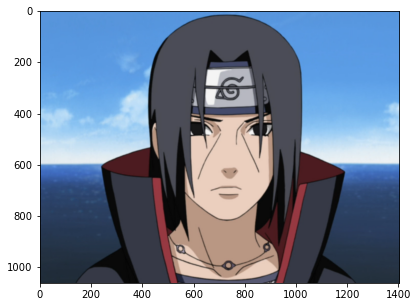

In [98]:
import matplotlib.pyplot as plt 
import tensorflow as tf

plt.rcParams['figure.figsize'] = (7, 5)
img = plt.imread('Itachi.png')
imgplot = plt.imshow(img)
plt.show()

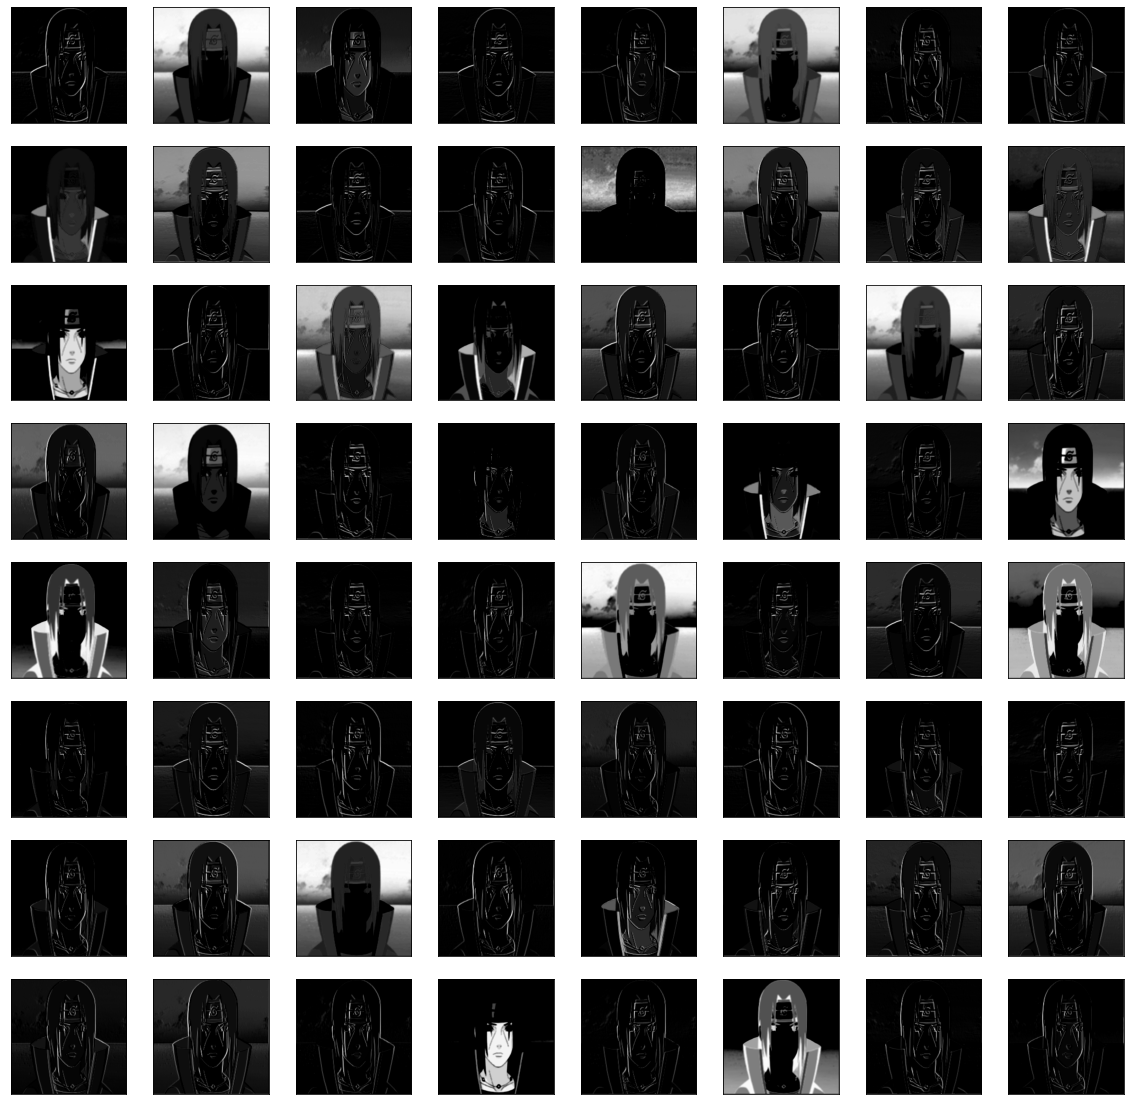

In [99]:
# Affichage des 64 feature map (image en noir et blanc)
square = 8
ix = 1
plt.rcParams['figure.figsize'] = (20, 20)

# load the image with the required shape
img = load_img('Itachi.png', target_size=(224, 224))

# convert the image to an array
img = img_to_array(img)
# expand dimensions so that it represents a single 'sample'
img = expand_dims(img, axis=0)

# prepare the image (e.g. scale pixel values for the vgg)
img = preprocess_input(img)
# get feature map for first hidden layer
feature_maps = model.predict(img)


for _ in range(square):
	for _ in range(square):
		# specify subplot and turn of axis
		ax = pyplot.subplot(square, square, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		pyplot.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
		ix += 1
# show the figure
pyplot.show()

**Exercice** : Vous testerez les codes précédents et modifierai la partie nécéssaire pour la visualisation des features maps d'une photo que vous aurez choisi.



# Solution:

In [100]:
%cd C:/Users/karim/Desktop
# Chargement du modèle pré-entraîné VGG16
model = VGG16()
# Sortie du modèle défini par la première convolution
model = Model(inputs=model.inputs, outputs=model.layers[1].output)
model.summary()
# Chargement de l'image
img = load_img('Conan.png', target_size=(224, 224))
# Conversion de l'image en numpy array
img = img_to_array(img)
img = expand_dims(img, axis=0)
# Normalisation des pixels
img = preprocess_input(img)
# Feature maps

C:\Users\karim\Desktop
Model: "functional_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
Total params: 1,792
Trainable params: 1,792
Non-trainable params: 0
_________________________________________________________________


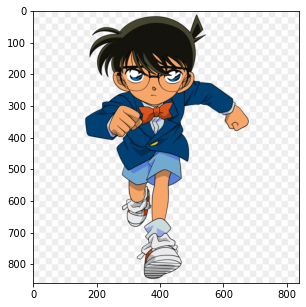

In [101]:
import matplotlib.pyplot as plt 
import tensorflow as tf

plt.rcParams['figure.figsize'] = (7, 5)
img = plt.imread('Conan.png')
imgplot = plt.imshow(img)
plt.show()

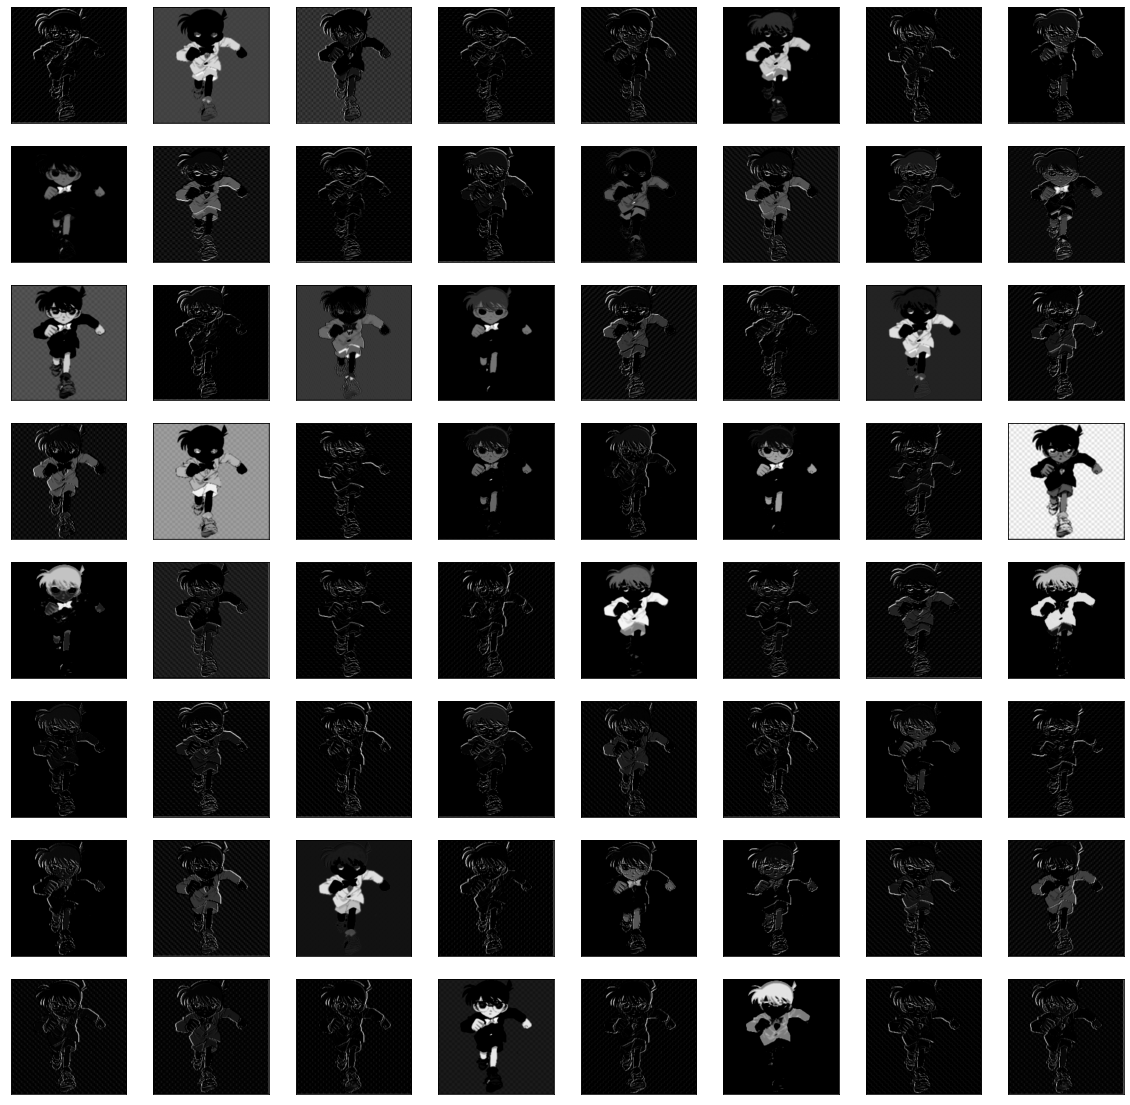

In [102]:
# Affichage des 64 feature map (image en noir et blanc)
square = 8
ix = 1
plt.rcParams['figure.figsize'] = (20, 20)

# load the image with the required shape
img = load_img('Conan.png', target_size=(224, 224))

# convert the image to an array
img = img_to_array(img)
# expand dimensions so that it represents a single 'sample'
img = expand_dims(img, axis=0)

# prepare the image (e.g. scale pixel values for the vgg)
img = preprocess_input(img)
# get feature map for first hidden layer
feature_maps = model.predict(img)


for _ in range(square):
	for _ in range(square):
		# specify subplot and turn of axis
		ax = pyplot.subplot(square, square, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		pyplot.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
		ix += 1
# show the figure
pyplot.show()

# Autoencoder

In [103]:
import keras
from keras import layers

Un Autoencodeur est un algorithme basé sur les réseaux de neurones de type non supervisé (sans label). Il apprend à comprésser les données et à les reconstruire à partir d'une représentation encodée. L'objectif étant que la reconstruction soit le plus fidèle possible à la donnée d'entrée.

Un Autoencodeur est composé de 4 parties:

* **1 - Encodeur** : partie dans lequel le modèle apprend à réduire et à compresser les données d'entrée en une représentation encodé.
* **2 - Bottleneck** : qui est la couche qui contient la représentation compressée des données d'entrée. Plus petite dimension.
* **3 - Decoder** : partie dans lequel le modèle apprend à reconstruire les données à partir de la représentation encodée pour être aussi proche que possible de l'entrée d'origine.
* **4 - Fonction de coût de reconstruction** : permet de mesurer la capacité du décodeur à reconstruire la donnée.

<img src='https://miro.medium.com/max/3148/1*44eDEuZBEsmG_TCAKRI3Kw@2x.png' width='800'>

<img src = 'https://blog.keras.io/img/ae/autoencoder_schema.jpg'>

In [104]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

print("Dimension X_train : ", X_train.shape)
print("Dimension y_train : ", y_train.shape)
print("Dimension X_test : ", X_test.shape)
print("Dimension y_test : ", y_test.shape)

Dimension X_train :  (60000, 28, 28)
Dimension y_train :  (60000,)
Dimension X_test :  (10000, 28, 28)
Dimension y_test :  (10000,)


__Exercice__ :  Implémentez un Autoencodeur à 6 couches : 
* 2 couches cachées pour la partie encodeur
* 1 couche représentant la représentation compréssée des données d'entrée 
* 3 couches cachées pour la partie decodeur (dont la couche de sortie)


In [105]:
from keras.models import Sequential, Model
from keras.layers import Dense
autoencoder = Sequential()

### START CODE HERE ### (approx. 6 lines)

# ENCODEUR - DENSE : 128 neurones + activation ReLU, input_shape=(784,)
autoencoder.add(Dense(128, activation='relu', input_dim=784, name="encodeur1"))

# ENCODEUR - DENSE : 64 neurones + activation ReLU
autoencoder.add(Dense(64, activation='relu', name="encodeur2"))

# BOTTLENECK - DENSE : 32 neurones + activation ReLU
autoencoder.add(Dense(32, activation='relu', name="bottleneck"))

# DECODEUR - DENSE : 64 neurones + activation ReLU
autoencoder.add(Dense(64, activation='relu', name="decodeur1"))

# DECODEUR - DENSE : 128 neurones + activation ReLU
autoencoder.add(Dense(128, activation='relu', name="decodeur2"))

### END CODE HERE ###

# DECODEUR
autoencoder.add(Dense(784,  activation='sigmoid'))

autoencoder.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encodeur1 (Dense)            (None, 128)               100480    
_________________________________________________________________
encodeur2 (Dense)            (None, 64)                8256      
_________________________________________________________________
bottleneck (Dense)           (None, 32)                2080      
_________________________________________________________________
decodeur1 (Dense)            (None, 64)                2112      
_________________________________________________________________
decodeur2 (Dense)            (None, 128)               8320      
_________________________________________________________________
dense_39 (Dense)             (None, 784)               101136    
Total params: 222,384
Trainable params: 222,384
Non-trainable params: 0
_______________________________________________

In [106]:
X_train = X_train.reshape(60000, 784)   # redimensionnement des 60,000 28 x 28 matrices en 60,000 vecteurs de dimension 784        
X_test = X_test.reshape(10000, 784)     # redimensionnement des 10,000 28 x 28 matrices en 10,000 vecteurs de dimension 784        

X_train = X_train.astype('float32')     # changement du type de données 
X_test = X_test.astype('float32')

X_train /= 255                          # normalisation des 784 pixels de chacune des images pour le training et le test
X_test /= 255

print("Dimension du jeu de données d'entraînement", X_train.shape)
print("Dimension du jeu de données de test", X_test.shape)

Dimension du jeu de données d'entraînement (60000, 784)
Dimension du jeu de données de test (10000, 784)


In [107]:
nb_classes = 10 # nombre de classes (0-9)

Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

In [108]:
autoencoder.compile(optimizer='adam', loss='mae')

autoencoder.fit(X_train, X_train, epochs=50, batch_size=256, shuffle=True, validation_data=(X_test, X_test))


Epoch 1/50
235/235 [==============================] - 2s 10ms/step - loss: 0.1399 - val_loss: 0.1127
Epoch 2/50
235/235 [==============================] - 2s 10ms/step - loss: 0.1057 - val_loss: 0.1019
Epoch 3/50
235/235 [==============================] - 2s 10ms/step - loss: 0.0975 - val_loss: 0.0943
Epoch 4/50
235/235 [==============================] - 2s 10ms/step - loss: 0.0925 - val_loss: 0.0922
Epoch 5/50
235/235 [==============================] - 2s 10ms/step - loss: 0.0902 - val_loss: 0.0895
Epoch 6/50
235/235 [==============================] - 2s 10ms/step - loss: 0.0877 - val_loss: 0.0872
Epoch 7/50
235/235 [==============================] - 2s 10ms/step - loss: 0.0857 - val_loss: 0.0854
Epoch 8/50
235/235 [==============================] - 2s 10ms/step - loss: 0.0836 - val_loss: 0.0827
Epoch 9/50
235/235 [==============================] - 2s 10ms/step - loss: 0.0816 - val_loss: 0.0810
Epoch 10/50
235/235 [==============================] - 2s 10ms/step - loss: 0.0799 - val_lo

**Exercice** :  Explicitez le calcul du nombre de paramètres de l'autoencoder.

# Solution:

### encodeur1 : 100480 = 128 (nbre de neurones) * 784 (nbre de input) + 128 (nbre neurones)

### encodeur2: 8256 = 64 (nbre de neurones) * 128 (nbre de neurones de la couche précedente) + 64 (nbre de neurones)

### bottleneck: 2080=  32 (nbre de neurones) *  64 (nbre de neurones de la couche précedente) + 32 (nbre de neurones)

### decodeur1: 2112=  64  (nbre de neurones) * 32  (nbre de neurones de la couche précedente)+ 64  (nbre de neurones)

### decodeur2: 8320 = 128 (nbre de neurones) * 64 (nbre de neurones de la couche précedente) +128 (nbre de neurones)

### decodeur3: 101136 = 784 (nbre de neurones) * 128  (nbre de neurones de la couche précedente) + 784 (nbre de neurones)

## Visualisation des images reconstruites

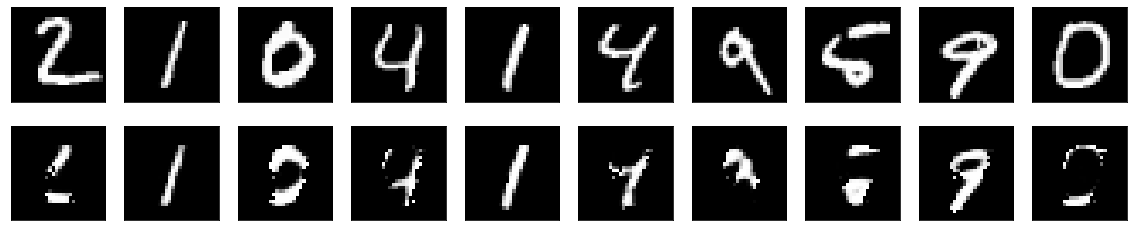

In [109]:
decoded_imgs = autoencoder.predict(X_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(X_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

**Exercice** : Vous ferez variez l'architecture de l'autoencoder (nombre de couche, de neurones) le batch size et le nombre d'epoch. Vous enregisterez pour chaque architecture un ensemble d'images reconstruites.

# Solution: Effets de nombre de couche

### nombre de couche: (2,1,3) -> (2,1,4)
### nombre de neurone: (128, 64, 32, 64, 128, 784)
### batch size: 256
### nombre d'epoch: 50

In [110]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

print("Dimension X_train : ", X_train.shape)
print("Dimension y_train : ", y_train.shape)
print("Dimension X_test : ", X_test.shape)
print("Dimension y_test : ", y_test.shape)

Dimension X_train :  (60000, 28, 28)
Dimension y_train :  (60000,)
Dimension X_test :  (10000, 28, 28)
Dimension y_test :  (10000,)


In [111]:
from keras.models import Sequential, Model
from keras.layers import Dense
autoencoder = Sequential()

### START CODE HERE ### (approx. 6 lines)

# ENCODEUR - DENSE : 128 neurones + activation ReLU, input_shape=(784,)
autoencoder.add(Dense(128, activation='relu', input_dim=784, name="encodeur1"))

# ENCODEUR - DENSE : 64 neurones + activation ReLU
autoencoder.add(Dense(64, activation='relu', name="encodeur2"))

# BOTTLENECK - DENSE : 32 neurones + activation ReLU
autoencoder.add(Dense(32, activation='relu', name="bottleneck"))

# DECODEUR - DENSE : 64 neurones + activation ReLU
autoencoder.add(Dense(64, activation='relu', name="decodeur1"))

# DECODEUR - DENSE : 128 neurones + activation ReLU
autoencoder.add(Dense(128, activation='relu', name="decodeur2"))

# DECODEUR - DENSE : 256 neurones + activation ReLU
autoencoder.add(Dense(256, activation='relu', name="decodeur3"))

### END CODE HERE ###

# DECODEUR
autoencoder.add(Dense(784,  activation='sigmoid'))

autoencoder.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encodeur1 (Dense)            (None, 128)               100480    
_________________________________________________________________
encodeur2 (Dense)            (None, 64)                8256      
_________________________________________________________________
bottleneck (Dense)           (None, 32)                2080      
_________________________________________________________________
decodeur1 (Dense)            (None, 64)                2112      
_________________________________________________________________
decodeur2 (Dense)            (None, 128)               8320      
_________________________________________________________________
decodeur3 (Dense)            (None, 256)               33024     
_________________________________________________________________
dense_40 (Dense)             (None, 784)             

In [112]:
X_train = X_train.reshape(60000, 784)   # redimensionnement des 60,000 28 x 28 matrices en 60,000 vecteurs de dimension 784        
X_test = X_test.reshape(10000, 784)     # redimensionnement des 10,000 28 x 28 matrices en 10,000 vecteurs de dimension 784        

X_train = X_train.astype('float32')     # changement du type de données 
X_test = X_test.astype('float32')

X_train /= 255                          # normalisation des 784 pixels de chacune des images pour le training et le test
X_test /= 255

print("Dimension du jeu de données d'entraînement", X_train.shape)
print("Dimension du jeu de données de test", X_test.shape)

nb_classes = 10 # nombre de classes (0-9)

Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)


Dimension du jeu de données d'entraînement (60000, 784)
Dimension du jeu de données de test (10000, 784)


In [113]:
autoencoder.compile(optimizer='adam', loss='mae')

autoencoder.fit(X_train, X_train, epochs=50, batch_size=256, shuffle=True, validation_data=(X_test, X_test))

Epoch 1/50
235/235 [==============================] - 3s 15ms/step - loss: 0.1386 - val_loss: 0.1181
Epoch 2/50
235/235 [==============================] - 3s 14ms/step - loss: 0.1109 - val_loss: 0.1044
Epoch 3/50
235/235 [==============================] - 3s 14ms/step - loss: 0.0985 - val_loss: 0.0936
Epoch 4/50
235/235 [==============================] - 3s 14ms/step - loss: 0.0893 - val_loss: 0.0861
Epoch 5/50
235/235 [==============================] - 3s 14ms/step - loss: 0.0816 - val_loss: 0.0777
Epoch 6/50
235/235 [==============================] - 3s 14ms/step - loss: 0.0741 - val_loss: 0.0706
Epoch 7/50
235/235 [==============================] - 3s 14ms/step - loss: 0.0689 - val_loss: 0.0666
Epoch 8/50
235/235 [==============================] - 3s 14ms/step - loss: 0.0656 - val_loss: 0.0645
Epoch 9/50
235/235 [==============================] - 3s 14ms/step - loss: 0.0625 - val_loss: 0.0603
Epoch 10/50
235/235 [==============================] - 3s 14ms/step - loss: 0.0594 - val_lo

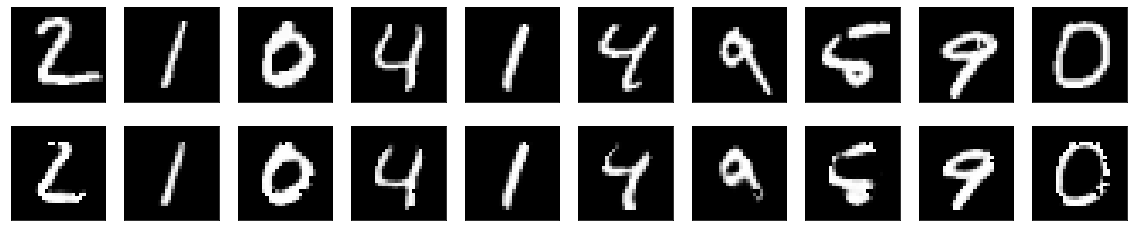

In [114]:
decoded_imgs = autoencoder.predict(X_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(X_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Solution: Effets de nombre de neurone

### nombre de couche: (2,1,3)
### nombre de neurone: (128, 64, 32, 64, 128, 784) -> (256, 128, 64, 128, 256, 1568)
### batch size: 256
### nombre d'epoch: 50

In [115]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

print("Dimension X_train : ", X_train.shape)
print("Dimension y_train : ", y_train.shape)
print("Dimension X_test : ", X_test.shape)
print("Dimension y_test : ", y_test.shape)

Dimension X_train :  (60000, 28, 28)
Dimension y_train :  (60000,)
Dimension X_test :  (10000, 28, 28)
Dimension y_test :  (10000,)


In [116]:
from keras.models import Sequential, Model
from keras.layers import Dense
autoencoder = Sequential()

### START CODE HERE ### (approx. 6 lines)

# ENCODEUR - DENSE : 256 neurones + activation ReLU, input_shape=(784,)
autoencoder.add(Dense(256, activation='relu', input_dim=784, name="encodeur1"))

# ENCODEUR - DENSE : 128 neurones + activation ReLU
autoencoder.add(Dense(128, activation='relu', name="encodeur2"))

# BOTTLENECK - DENSE : 64 neurones + activation ReLU
autoencoder.add(Dense(64, activation='relu', name="bottleneck"))

# DECODEUR - DENSE : 128 neurones + activation ReLU
autoencoder.add(Dense(128, activation='relu', name="decodeur1"))

# DECODEUR - DENSE : 256 neurones + activation ReLU
autoencoder.add(Dense(256, activation='relu', name="decodeur2"))

### END CODE HERE ###

# DECODEUR
autoencoder.add(Dense(784,  activation='sigmoid'))

autoencoder.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encodeur1 (Dense)            (None, 256)               200960    
_________________________________________________________________
encodeur2 (Dense)            (None, 128)               32896     
_________________________________________________________________
bottleneck (Dense)           (None, 64)                8256      
_________________________________________________________________
decodeur1 (Dense)            (None, 128)               8320      
_________________________________________________________________
decodeur2 (Dense)            (None, 256)               33024     
_________________________________________________________________
dense_41 (Dense)             (None, 784)               201488    
Total params: 484,944
Trainable params: 484,944
Non-trainable params: 0
_______________________________________________

In [117]:
X_train = X_train.reshape(60000, 784)   # redimensionnement des 60,000 28 x 28 matrices en 60,000 vecteurs de dimension 784        
X_test = X_test.reshape(10000, 784)     # redimensionnement des 10,000 28 x 28 matrices en 10,000 vecteurs de dimension 784        

X_train = X_train.astype('float32')     # changement du type de données 
X_test = X_test.astype('float32')

X_train /= 255                          # normalisation des 784 pixels de chacune des images pour le training et le test
X_test /= 255

print("Dimension du jeu de données d'entraînement", X_train.shape)
print("Dimension du jeu de données de test", X_test.shape)

nb_classes = 10 # nombre de classes (0-9)

Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)


Dimension du jeu de données d'entraînement (60000, 784)
Dimension du jeu de données de test (10000, 784)


In [118]:
autoencoder.compile(optimizer='adam', loss='mae')

autoencoder.fit(X_train, X_train, epochs=50, batch_size=256, shuffle=True, validation_data=(X_test, X_test))

Epoch 1/50
235/235 [==============================] - 4s 19ms/step - loss: 0.1351 - val_loss: 0.1128
Epoch 2/50
235/235 [==============================] - 4s 17ms/step - loss: 0.1054 - val_loss: 0.1002
Epoch 3/50
235/235 [==============================] - 4s 17ms/step - loss: 0.0947 - val_loss: 0.0909
Epoch 4/50
235/235 [==============================] - 4s 17ms/step - loss: 0.0872 - val_loss: 0.0845
Epoch 5/50
235/235 [==============================] - 4s 17ms/step - loss: 0.0827 - val_loss: 0.0819
Epoch 6/50
235/235 [==============================] - 4s 17ms/step - loss: 0.0798 - val_loss: 0.0784
Epoch 7/50
235/235 [==============================] - 4s 17ms/step - loss: 0.0768 - val_loss: 0.0761
Epoch 8/50
235/235 [==============================] - 4s 17ms/step - loss: 0.0753 - val_loss: 0.0753
Epoch 9/50
235/235 [==============================] - 4s 17ms/step - loss: 0.0738 - val_loss: 0.0735
Epoch 10/50
235/235 [==============================] - 4s 17ms/step - loss: 0.0725 - val_lo

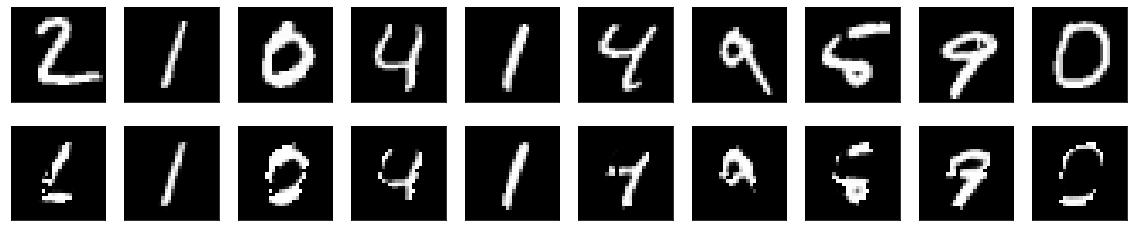

In [119]:
decoded_imgs = autoencoder.predict(X_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(X_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Solution: effet de batch size:

### nombre de couche: (2,1,3)
### nombre de neurone: (128, 64, 32, 64, 128, 784)
### batch size: 256 -> 512
### nombre d'epoch: 50

In [120]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

print("Dimension X_train : ", X_train.shape)
print("Dimension y_train : ", y_train.shape)
print("Dimension X_test : ", X_test.shape)
print("Dimension y_test : ", y_test.shape)

Dimension X_train :  (60000, 28, 28)
Dimension y_train :  (60000,)
Dimension X_test :  (10000, 28, 28)
Dimension y_test :  (10000,)


In [121]:
from keras.models import Sequential, Model
from keras.layers import Dense
autoencoder = Sequential()

### START CODE HERE ### (approx. 6 lines)

# ENCODEUR - DENSE : 128 neurones + activation ReLU, input_shape=(784,)
autoencoder.add(Dense(128, activation='relu', input_dim=784, name="encodeur1"))

# ENCODEUR - DENSE : 64 neurones + activation ReLU
autoencoder.add(Dense(64, activation='relu', name="encodeur2"))

# BOTTLENECK - DENSE : 32 neurones + activation ReLU
autoencoder.add(Dense(32, activation='relu', name="bottleneck"))

# DECODEUR - DENSE : 64 neurones + activation ReLU
autoencoder.add(Dense(64, activation='relu', name="decodeur1"))

# DECODEUR - DENSE : 128 neurones + activation ReLU
autoencoder.add(Dense(128, activation='relu', name="decodeur2"))

### END CODE HERE ###

# DECODEUR
autoencoder.add(Dense(784,  activation='sigmoid'))

autoencoder.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encodeur1 (Dense)            (None, 128)               100480    
_________________________________________________________________
encodeur2 (Dense)            (None, 64)                8256      
_________________________________________________________________
bottleneck (Dense)           (None, 32)                2080      
_________________________________________________________________
decodeur1 (Dense)            (None, 64)                2112      
_________________________________________________________________
decodeur2 (Dense)            (None, 128)               8320      
_________________________________________________________________
dense_42 (Dense)             (None, 784)               101136    
Total params: 222,384
Trainable params: 222,384
Non-trainable params: 0
_______________________________________________

In [122]:
X_train = X_train.reshape(60000, 784)   # redimensionnement des 60,000 28 x 28 matrices en 60,000 vecteurs de dimension 784        
X_test = X_test.reshape(10000, 784)     # redimensionnement des 10,000 28 x 28 matrices en 10,000 vecteurs de dimension 784        

X_train = X_train.astype('float32')     # changement du type de données 
X_test = X_test.astype('float32')

X_train /= 255                          # normalisation des 784 pixels de chacune des images pour le training et le test
X_test /= 255

print("Dimension du jeu de données d'entraînement", X_train.shape)
print("Dimension du jeu de données de test", X_test.shape)

nb_classes = 10 # nombre de classes (0-9)

Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)


Dimension du jeu de données d'entraînement (60000, 784)
Dimension du jeu de données de test (10000, 784)


In [123]:
autoencoder.compile(optimizer='adam', loss='mae')

autoencoder.fit(X_train, X_train, epochs=50, batch_size=512, shuffle=True, validation_data=(X_test, X_test))

Epoch 1/50
118/118 [==============================] - 3s 23ms/step - loss: 0.1613 - val_loss: 0.1253
Epoch 2/50
118/118 [==============================] - 3s 23ms/step - loss: 0.1172 - val_loss: 0.1119
Epoch 3/50
118/118 [==============================] - 3s 22ms/step - loss: 0.1080 - val_loss: 0.1062
Epoch 4/50
118/118 [==============================] - 3s 23ms/step - loss: 0.1041 - val_loss: 0.1040
Epoch 5/50
118/118 [==============================] - 3s 22ms/step - loss: 0.1026 - val_loss: 0.1024
Epoch 6/50
118/118 [==============================] - 3s 22ms/step - loss: 0.1007 - val_loss: 0.1000
Epoch 7/50
118/118 [==============================] - 3s 22ms/step - loss: 0.0974 - val_loss: 0.0963
Epoch 8/50
118/118 [==============================] - 3s 22ms/step - loss: 0.0949 - val_loss: 0.0943
Epoch 9/50
118/118 [==============================] - 3s 22ms/step - loss: 0.0933 - val_loss: 0.0930
Epoch 10/50
118/118 [==============================] - 3s 21ms/step - loss: 0.0919 - val_lo

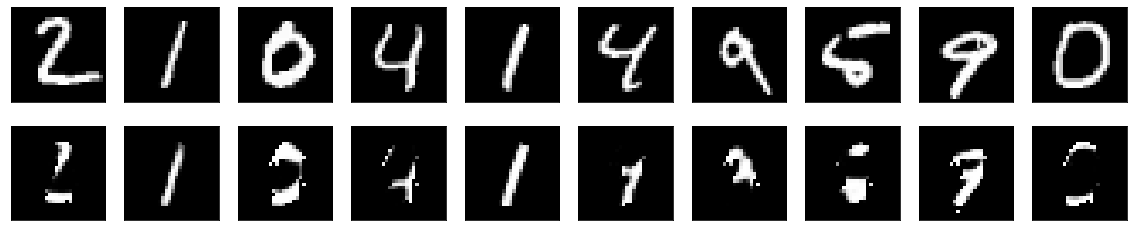

In [124]:
decoded_imgs = autoencoder.predict(X_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(X_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Solution: effet de nombre d'epoch:

### nombre de couche: (2,1,3)
### nombre de neurone: (128, 64, 32, 64, 128, 784)
### batch size: 256
### nombre d'epoch: 50 -> 100

In [125]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

print("Dimension X_train : ", X_train.shape)
print("Dimension y_train : ", y_train.shape)
print("Dimension X_test : ", X_test.shape)
print("Dimension y_test : ", y_test.shape)

Dimension X_train :  (60000, 28, 28)
Dimension y_train :  (60000,)
Dimension X_test :  (10000, 28, 28)
Dimension y_test :  (10000,)


In [126]:
from keras.models import Sequential, Model
from keras.layers import Dense
autoencoder = Sequential()

### START CODE HERE ### (approx. 6 lines)

# ENCODEUR - DENSE : 128 neurones + activation ReLU, input_shape=(784,)
autoencoder.add(Dense(128, activation='relu', input_dim=784, name="encodeur1"))

# ENCODEUR - DENSE : 64 neurones + activation ReLU
autoencoder.add(Dense(64, activation='relu', name="encodeur2"))

# BOTTLENECK - DENSE : 32 neurones + activation ReLU
autoencoder.add(Dense(32, activation='relu', name="bottleneck"))

# DECODEUR - DENSE : 64 neurones + activation ReLU
autoencoder.add(Dense(64, activation='relu', name="decodeur1"))

# DECODEUR - DENSE : 128 neurones + activation ReLU
autoencoder.add(Dense(128, activation='relu', name="decodeur2"))

### END CODE HERE ###

# DECODEUR
autoencoder.add(Dense(784,  activation='sigmoid'))

autoencoder.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encodeur1 (Dense)            (None, 128)               100480    
_________________________________________________________________
encodeur2 (Dense)            (None, 64)                8256      
_________________________________________________________________
bottleneck (Dense)           (None, 32)                2080      
_________________________________________________________________
decodeur1 (Dense)            (None, 64)                2112      
_________________________________________________________________
decodeur2 (Dense)            (None, 128)               8320      
_________________________________________________________________
dense_43 (Dense)             (None, 784)               101136    
Total params: 222,384
Trainable params: 222,384
Non-trainable params: 0
_______________________________________________

In [127]:
X_train = X_train.reshape(60000, 784)   # redimensionnement des 60,000 28 x 28 matrices en 60,000 vecteurs de dimension 784        
X_test = X_test.reshape(10000, 784)     # redimensionnement des 10,000 28 x 28 matrices en 10,000 vecteurs de dimension 784        

X_train = X_train.astype('float32')     # changement du type de données 
X_test = X_test.astype('float32')

X_train /= 255                          # normalisation des 784 pixels de chacune des images pour le training et le test
X_test /= 255

print("Dimension du jeu de données d'entraînement", X_train.shape)
print("Dimension du jeu de données de test", X_test.shape)

nb_classes = 10 # nombre de classes (0-9)

Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)


Dimension du jeu de données d'entraînement (60000, 784)
Dimension du jeu de données de test (10000, 784)


In [128]:
autoencoder.compile(optimizer='adam', loss='mae')

autoencoder.fit(X_train, X_train, epochs=100, batch_size=256, shuffle=True, validation_data=(X_test, X_test))

Epoch 1/100
235/235 [==============================] - 3s 11ms/step - loss: 0.1442 - val_loss: 0.1175
Epoch 2/100
235/235 [==============================] - 2s 10ms/step - loss: 0.1106 - val_loss: 0.1056
Epoch 3/100
235/235 [==============================] - 2s 10ms/step - loss: 0.1002 - val_loss: 0.0972
Epoch 4/100
235/235 [==============================] - 2s 10ms/step - loss: 0.0937 - val_loss: 0.0918
Epoch 5/100
235/235 [==============================] - 2s 10ms/step - loss: 0.0892 - val_loss: 0.0872
Epoch 6/100
235/235 [==============================] - 2s 10ms/step - loss: 0.0852 - val_loss: 0.0835
Epoch 7/100
235/235 [==============================] - 2s 10ms/step - loss: 0.0813 - val_loss: 0.0799
Epoch 8/100
235/235 [==============================] - 2s 10ms/step - loss: 0.0788 - val_loss: 0.0776
Epoch 9/100
235/235 [==============================] - 2s 10ms/step - loss: 0.0767 - val_loss: 0.0760
Epoch 10/100
235/235 [==============================] - 2s 10ms/step - loss: 0.075

235/235 [==============================] - 2s 10ms/step - loss: 0.0547 - val_loss: 0.0543
Epoch 81/100
235/235 [==============================] - 2s 10ms/step - loss: 0.0545 - val_loss: 0.0542
Epoch 82/100
235/235 [==============================] - 2s 10ms/step - loss: 0.0545 - val_loss: 0.0541
Epoch 83/100
235/235 [==============================] - 3s 11ms/step - loss: 0.0544 - val_loss: 0.0540
Epoch 84/100
235/235 [==============================] - 2s 11ms/step - loss: 0.0542 - val_loss: 0.0540
Epoch 85/100
235/235 [==============================] - 2s 11ms/step - loss: 0.0542 - val_loss: 0.0539
Epoch 86/100
235/235 [==============================] - 2s 10ms/step - loss: 0.0542 - val_loss: 0.0539
Epoch 87/100
235/235 [==============================] - 2s 10ms/step - loss: 0.0541 - val_loss: 0.0540
Epoch 88/100
235/235 [==============================] - 2s 11ms/step - loss: 0.0537 - val_loss: 0.0532
Epoch 89/100
235/235 [==============================] - 2s 10ms/step - loss: 0.0532 - 

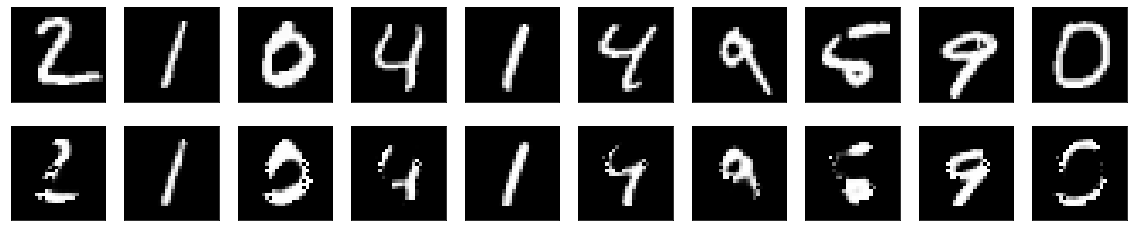

In [129]:
decoded_imgs = autoencoder.predict(X_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(X_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

**Exercice** : Vous développerez une architecture qui dépassera les 99.5% d'accuracy sur les données test.


**Exercice** : Vous développerez une architecture qui dépassera l'accuracy sur les données test de tout les autres groupes de TP.

<img src="https://pbs.twimg.com/media/EqXf08kVQAAJl3L.jpg" />